In [4]:
!pip -q install nbformat==5.10.4

import nbformat as nbf
from pathlib import Path

# 🔁 Cambia esto por el nombre real de tu notebook en Colab
# SRC = "/content/Proyecto_Data_Fraude_Completo (4).ipynb" # Original path
SRC = "/content/dataset_final_limpio.csv" # Updated path to the downloaded dataset
DST = "/content/Proyecto_Data_Fraude_Completo_CLEAN.ipynb" # This will now output a cleaned CSV, not an IPYNB

# The following code is designed to clean an .ipynb file, not a .csv file.
# It will be commented out as it is not applicable to the updated SRC.
# If you intended to clean a notebook, please ensure the correct path is provided.

# nb = nbf.read(SRC, as_version=4)

# # 1) Eliminar metadatos problemáticos de widgets
# if "widgets" in nb.metadata:
#     nb.metadata.pop("widgets", None)

# # (Opcional) limpiar outputs y execution_count para un commit “pro”
# for cell in nb.cells:
#     cell.metadata.pop("widgets", None)  # por si algún cell tiene metadatos de widgets
#     if "outputs" in cell: cell["outputs"] = []
#     cell["execution_count"] = None

# nbf.write(nb, DST)
# print(f"✅ Notebook limpio guardado en: {DST}")

# To demonstrate reading the updated file path:
import pandas as pd
try:
    df_cleaned = pd.read_csv(SRC)
    print(f"✅ Successfully read data from: {SRC}")
    # You can add cleaning steps for the CSV here if needed
    # display(df_cleaned.head())
except FileNotFoundError:
    print(f"❌ Error: File not found at {SRC}")

✅ Successfully read data from: /content/dataset_final_limpio.csv


# Setup & Librerias #

In [ ]:
# =========================
# 📦 Librerías y Config Base
# =========================

# --- Generales / Sistema ---
import os
import json
import gc
import logging
import warnings
from pathlib import Path
from datetime import datetime

# --- Datos / Numérico ---
import numpy as np
import pandas as pd

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- ML / Preprocesamiento ---
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# --- Métricas ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc
)

# --- Tuning ---
from scipy.stats import randint, uniform

# --- Desbalance (opcional) ---
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except Exception:
    SMOTE_AVAILABLE = False

# --- Modelo principal ---
try:
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True
except Exception:
    LGBM_AVAILABLE = False

# --- Persistencia ---
import joblib

# --- Explainability (opcional) ---
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# --- Drift (opcional) ---
try:
    from evidently.report import Report
    from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
    EVIDENTLY_AVAILABLE = True
except Exception:
    EVIDENTLY_AVAILABLE = False

# --- Utilidades Jupyter ---
from IPython.display import display, HTML

# =========================
# 🎛️ Configuración Global
# =========================
# Estilo de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

# Mostrar más columnas en dataframes
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 1000)

# Logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# Ignorar warnings ruidosos
warnings.filterwarnings("ignore")

# Reproducibilidad
SEED = 42
np.random.seed(SEED)

# =========================
# 📁 Rutas y Constantes
# =========================
# Ajusta estas rutas si usas Google Drive o local
DATA_DIR = Path("/content")
ARTIFACTS_DIR = DATA_DIR / "artifacts_v4"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

CARDS_CSV = DATA_DIR / "cards_data.csv"
USERS_CSV = DATA_DIR / "users_data.csv"
TX_CSV    = DATA_DIR / "transactions_data.csv"
DATASET_FINAL = DATA_DIR / "dataset_fraude_final.csv"

# Fecha de referencia para features temporales (coherente con el proyecto)
REF_DATE = pd.Timestamp("2025-07-23")

# =========================
# 🔎 Estado de librerías clave
# =========================
if not LGBM_AVAILABLE:
    logging.warning("LightGBM no está instalado. (En Colab: !pip install lightgbm)")
if not SHAP_AVAILABLE:
    logging.warning("SHAP no está instalado. (En Colab: !pip install shap)")
if not EVIDENTLY_AVAILABLE:
    logging.warning("Evidently no está instalado. (En Colab: !pip install evidently)")
if not SMOTE_AVAILABLE:
    logging.info("imblearn/SMOTE no disponible. Continuaremos sin sobre-muestreo.")


In [ ]:
!pip install evidently

In [ ]:
!pip install lightgbm shap evidently imbalanced-learn -q
!pip install shap
!pip install evidently

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.5/236.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 k

#Carga de Datos y Sanity Checks #

In [3]:
# ✅ 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ 2. Definir la ruta donde guardaste los archivos
project_path = '/content/drive/MyDrive/Proyecto_Fraude'

# ✅ 3. Descargar los archivos del proyecto a la sesión actual
import shutil
import os

archivos = [
    'cards_data.csv',
    'transactions_data.csv',
    'users_data.csv',
    'dataset_final_limpio.csv'


]

os.makedirs('/content', exist_ok=True)

for archivo in archivos:
    origen = os.path.join(project_path, archivo)
    destino = os.path.join('/content', archivo)
    if os.path.exists(origen):
        shutil.copy(origen, destino)
        print(f"✅ {archivo} descargado en {destino}")
    else:
        print(f"⚠️ {archivo} no encontrado en Drive")

# ✅ 4. Ruta final para usar los archivos directamente
ruta = '/content'

print("\n🎉 ✅ Archivos descargados correctamente, podés cargarlos así:\n")
print(f"df_cards = pd.read_csv('{ruta}/cards_data.csv')")
print(f"df_transactions = pd.read_csv('{ruta}/transactions_data.csv')")
print(f"df_users = pd.read_csv('{ruta}/users_data.csv')")

Mounted at /content/drive
✅ cards_data.csv descargado en /content/cards_data.csv
✅ transactions_data.csv descargado en /content/transactions_data.csv
✅ users_data.csv descargado en /content/users_data.csv
✅ dataset_final_limpio.csv descargado en /content/dataset_final_limpio.csv

🎉 ✅ Archivos descargados correctamente, podés cargarlos así:

df_cards = pd.read_csv('/content/cards_data.csv')
df_transactions = pd.read_csv('/content/transactions_data.csv')
df_users = pd.read_csv('/content/users_data.csv')


# Describe de los Datasets #

In [ ]:
# ==============================
# 1) CARGA + SUPER DESCRIBE
# ==============================

import pandas as pd
import numpy as np

# Rutas dadas
df_cards = pd.read_csv('/content/cards_data.csv')
df_transactions = pd.read_csv('/content/transactions_data.csv')
df_users = pd.read_csv('/content/users_data.csv')

def super_describe(df: pd.DataFrame, name: str, n_cat_top: int = 10):
    print(f"\n{'='*80}")
    print(f"📦 Dataset: {name}")
    print(f"{'-'*80}")
    print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print("Columnas:", list(df.columns))
    print("\nTipos:")
    print(df.dtypes)

    # Nulos
    print("\n% Nulos por columna (top 20):")
    nulls = (df.isnull().mean() * 100).sort_values(ascending=False).head(20)
    print(nulls.round(2))

    # Duplicados por una posible PK
    if 'id' in df.columns:
        dups = df['id'].duplicated().sum()
        print(f"\nPosibles duplicados por 'id': {dups}")
    elif 'card_id' in df.columns:
        dups = df['card_id'].duplicated().sum()
        print(f"\nPosibles duplicados por 'card_id': {dups}")
    elif 'user_id' in df.columns:
        dups = df['user_id'].duplicated().sum()
        print(f"\nPosibles duplicados por 'user_id': {dups}")

    # Numéricas – estadísticos
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    if num_cols:
        print("\n📊 Estadísticos numéricos (primeras 10 columnas):")
        print(df[num_cols].describe(percentiles=[.01, .05, .5, .95, .99]).T.head(10).round(2))

    # Categóricas – cardinalidad y top categorías
    cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    if cat_cols:
        print("\n🔤 Categóricas (cardinalidad):")
        card = {c: df[c].nunique(dropna=True) for c in cat_cols}
        print(pd.Series(card).sort_values(ascending=False).head(20))
        print("\nTop categorías por columna (muestra):")
        for c in cat_cols[:5]:
            print(f"  - {c}:")
            print(df[c].value_counts(dropna=False).head(n_cat_top))

    # Preview
    print("\n👀 Head:")
    display(df.head(3))
    print('='*80)

# Ejecutar describe para cada tabla
super_describe(df_transactions, "Transactions")
super_describe(df_cards, "Cards")
super_describe(df_users, "Users")



📦 Dataset: Transactions
--------------------------------------------------------------------------------
Dimensiones: 13305915 filas x 12 columnas
Columnas: ['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors']

Tipos:
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

% Nulos por columna (top 20):
errors            98.41
zip               12.42
merchant_state    11.75
id                 0.00
card_id            0.00
client_id          0.00
date               0.00
amount             0.00
merchant_city      0.00
merchant_id        0.00
use_chip           0.00
mcc                0.00
dtype: float64

Posibles duplicados por 'id': 0

📊 Est

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN



📦 Dataset: Cards
--------------------------------------------------------------------------------
Dimensiones: 6146 filas x 13 columnas
Columnas: ['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web']

Tipos:
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

% Nulos por columna (top 20):
id                       0.0
client_id                0.0
card_brand               0.0
card_type                0.0
card_number              0.0
expires                  0.0
cvv                

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No



📦 Dataset: Users
--------------------------------------------------------------------------------
Dimensiones: 2000 filas x 14 columnas
Columnas: ['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month', 'gender', 'address', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards']

Tipos:
id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object

% Nulos por columna (top 20):
id                   0.0
current_age          0.0
retirement_age       0.0
birth_year           0.0
birth_month          0.0
gender               0.0
address              0.0
latitude        

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5


# Limpiezas/ ETL por Datasets #

In [ ]:
# ==============================
# 2) ETL POR TABLA (SILVER)
# ==============================

import pandas as pd
import numpy as np

REF_DATE = pd.Timestamp("2025-07-23")  # coherente con lo usado en el proyecto

def _parse_money(s):
    return pd.to_numeric(str(s).replace('$','').replace(',',''), errors='coerce')

def _to_dt(s, fmt=None):
    try:
        if fmt:
            return pd.to_datetime(s, format=fmt, errors='coerce')
        return pd.to_datetime(s, errors='coerce')
    except Exception:
        return pd.to_datetime(s, errors='coerce')

def _map_yes_no(series):
    return series.astype(str).str.strip().str.lower().map({'yes':1, 'no':0})

def _fix_coord(series, kind='lat'):
    """
    Corrige lat/long que vengan como 4074 -> 40.74, o 12258 -> 122.58
    - Para lat: límites razonables [-90, 90]
    - Para lon: límites razonables [-180, 180]
    Si detecta valores fuera de rango, intenta dividir por 100.
    """
    s = pd.to_numeric(series, errors='coerce')
    if kind == 'lat':
        bad = (s.abs() > 90)
    else:
        bad = (s.abs() > 180)
    s.loc[bad] = s.loc[bad] / 100.0
    return s

# ---------- Transactions ----------
def clean_transactions(df_tx: pd.DataFrame) -> pd.DataFrame:
    df = df_tx.copy()

    # Fechas y componentes temporales
    if 'date' in df.columns:
        df['date'] = _to_dt(df['date'])
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.dayofweek
        df['hour'] = df['date'].dt.hour
        df['is_off_hours'] = df['hour'].isin(list(range(0,6)) + [23]).astype(int)
    else:
        df['is_off_hours'] = 0

    # Monto
    if 'amount' in df.columns:
        df['amount'] = df['amount'].apply(_parse_money)

    # Errores -> flag binaria
    if 'errors' in df.columns:
        df['has_error'] = (~df['errors'].isna() & (df['errors'].astype(str).str.len() > 0)).astype(int)
    else:
        df['has_error'] = 0

    # use_chip -> flag
    if 'use_chip' in df.columns:
        df['use_chip_flag'] = df['use_chip'].astype(str).str.contains('chip', case=False, na=False).astype(int)
    else:
        df['use_chip_flag'] = 0

    # Tipos/limpiezas suaves
    for c in ['client_id','card_id','merchant_id','zip','mcc']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Dedupe por transaction id si existe
    if 'id' in df.columns:
        df = df.drop_duplicates(subset=['id'])

    return df


# ---------- Cards ----------
def clean_cards(df_cards: pd.DataFrame, ref_date=REF_DATE) -> pd.DataFrame:
    df = df_cards.copy()

    # Normalizar key
    if 'id' in df.columns and 'card_id' not in df.columns:
        df.rename(columns={'id':'card_id'}, inplace=True)

    # Montos/fechas
    if 'credit_limit' in df.columns:
        df['credit_limit'] = df['credit_limit'].astype(str).str.replace('[\\$,]','', regex=True)
        df['credit_limit'] = pd.to_numeric(df['credit_limit'], errors='coerce')

    if 'acct_open_date' in df.columns:
        df['acct_open_date'] = _to_dt(df['acct_open_date'])
        df['account_age_days'] = (ref_date - df['acct_open_date']).dt.days

    if 'expires' in df.columns:
        exp = _to_dt(df['expires'], fmt='%m/%y')
        df['expires'] = exp.fillna(_to_dt(df['expires']))
        df['is_expired'] = (df['expires'] < ref_date).astype(int)
    else:
        df['is_expired'] = np.nan

    if 'year_pin_last_changed' in df.columns:
        df['years_since_pin_change'] = ref_date.year - pd.to_numeric(df['year_pin_last_changed'], errors='coerce')
    else:
        df['years_since_pin_change'] = np.nan

    # Binarios YES/NO
    if 'has_chip' in df.columns:
        df['has_chip'] = _map_yes_no(df['has_chip']).fillna(df['has_chip']).astype(float)
    if 'card_on_dark_web' in df.columns:
        df['card_on_dark_web'] = _map_yes_no(df['card_on_dark_web']).fillna(df['card_on_dark_web']).astype(float)

    # Tipos
    for c in ['card_id','client_id','num_cards_issued']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Dedupe por card_id si existe
    if 'card_id' in df.columns:
        df = df.drop_duplicates(subset=['card_id'])

    return df


# ---------- Users ----------
def clean_users(df_users: pd.DataFrame) -> pd.DataFrame:
    df = df_users.copy()

    # Normalizar key
    if 'id' in df.columns and 'user_id' not in df.columns:
        df.rename(columns={'id':'user_id'}, inplace=True)

    # Coords
    # Nota: si ya vienen bien (p.ej. 40.74, -73.99) esto no los toca.
    for c in df.columns:
        lc = c.lower()
        if lc in ('latitude','lat','user_lat'):
            df[c] = _fix_coord(df[c], kind='lat')
        if lc in ('longitude','lon','lng','user_lon'):
            df[c] = _fix_coord(df[c], kind='lon')

    # Tipos numéricos
    num_suspects = [
        'current_age','retirement_age','birth_year','birth_month',
        'per_capita_income','yearly_income','total_debt','credit_score','num_credit_cards'
    ]
    for c in num_suspects:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Dedupe por user_id
    if 'user_id' in df.columns:
        df = df.drop_duplicates(subset=['user_id'])

    return df


# ===== Ejecutar limpieza por tabla =====
df_transactions_clean = clean_transactions(df_transactions)
df_cards_clean = clean_cards(df_cards, ref_date=REF_DATE)
df_users_clean = clean_users(df_users)

print("✅ Limpieza OK")
print("transactions_clean:", df_transactions_clean.shape)
print("cards_clean:", df_cards_clean.shape)
print("users_clean:", df_users_clean.shape)

# Visual quick-check
display(df_transactions_clean.head(3))
display(df_cards_clean.head(3))
display(df_users_clean.head(3))


✅ Limpieza OK
transactions_clean: (13305915, 19)
cards_clean: (6146, 16)
users_clean: (2000, 14)


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,year,month,day_of_week,hour,is_off_hours,has_error,use_chip_flag
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,2010,1,4,0,1,0,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,2010,1,4,0,1,0,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,2010,1,4,0,1,0,0


,card_id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,account_age_days,is_expired,years_since_pin_change
0,4524,825,Visa,Debit,4344676511950444,2022-12-01,623,1.0,2,24295,2002-09-01,2008,0.0,8361,1,17
1,2731,825,Visa,Debit,4956965974959986,2020-12-01,393,1.0,2,21968,2014-04-01,2014,0.0,4131,1,11
2,3701,825,Visa,Debit,4582313478255491,2024-02-01,719,1.0,2,46414,2003-07-01,2004,0.0,8058,1,21


,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,NaN,NaN,NaN,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,NaN,NaN,NaN,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,NaN,NaN,NaN,698,5


# Integracion de tablas/ Datasets_Final #

In [ ]:
# ================================================
# 3) INTEGRACIÓN (GOLD) + TARGET + EXPORT FINAL
# ================================================

import pandas as pd
import numpy as np

# --- 3.1 Validaciones suaves de claves antes del join ---
if 'card_id' not in df_transactions_clean.columns:
    raise ValueError("❌ 'df_transactions_clean' no tiene 'card_id' (necesario para unir con Cards).")

if 'card_id' not in df_cards_clean.columns:
    raise ValueError("❌ 'df_cards_clean' no tiene 'card_id' (revisa la limpieza de Cards).")

# --- 3.2 Join: Transactions ⟶ Cards (LEFT) ---
df_merge1 = df_transactions_clean.merge(
    df_cards_clean,
    on='card_id',
    how='left',
    suffixes=('_tx', '_card')
)

# --- 3.3 Preparar Users para join (user_id → client_id) ---
if 'user_id' in df_users_clean.columns and 'client_id' not in df_users_clean.columns:
    df_users_for_merge = df_users_clean.rename(columns={'user_id': 'client_id'}).copy()
else:
    df_users_for_merge = df_users_clean.copy()

# Si por algún motivo la transacción no tiene 'client_id' con ese nombre exacto, intentamos variantes
if 'client_id' not in df_merge1.columns:
    # Casos vistos en integraciones previas
    if 'client_id_tx' in df_merge1.columns:
        df_merge1.rename(columns={'client_id_tx': 'client_id'}, inplace=True)
    elif 'client_id_card' in df_merge1.columns:
        df_merge1.rename(columns={'client_id_card': 'client_id'}, inplace=True)

# --- 3.4 Join: (Tx+Cards) ⟶ Users (LEFT) ---
if 'client_id' in df_merge1.columns and 'client_id' in df_users_for_merge.columns:
    df_final = df_merge1.merge(df_users_for_merge, on='client_id', how='left')
else:
    # Si no hay client_id, continuamos sin unir Users (lo reportamos)
    print("⚠️ Aviso: No se pudo unir con Users por falta de 'client_id'. Se continúa con Tx+Cards.")
    df_final = df_merge1.copy()

# --- 3.5 Limpieza de columnas sensibles / redundantes ---
cols_sensibles = ['card_number', 'cvv']
df_final.drop(columns=[c for c in cols_sensibles if c in df_final.columns], inplace=True, errors='ignore')

# --- 3.6 (Opcional) Normalizar tipos críticos por seguridad ---
# Aseguramos numéricos donde corresponde (no rompe si faltan)
for c in ['amount', 'credit_limit', 'num_cards_issued', 'years_since_pin_change', 'account_age_days']:
    if c in df_final.columns:
        df_final[c] = pd.to_numeric(df_final[c], errors='coerce')

# --- 3.7 Features mínimas (si faltan, las creamos) ---
# has_error
if 'has_error' not in df_final.columns and 'errors' in df_final.columns:
    df_final['has_error'] = (~df_final['errors'].isna() & (df_final['errors'].astype(str).str.len() > 0)).astype(int)
elif 'has_error' not in df_final.columns:
    df_final['has_error'] = 0

# use_chip_flag
if 'use_chip_flag' not in df_final.columns and 'use_chip' in df_final.columns:
    df_final['use_chip_flag'] = df_final['use_chip'].astype(str).str.contains('chip', case=False, na=False).astype(int)
elif 'use_chip_flag' not in df_final.columns:
    df_final['use_chip_flag'] = 0

# --- 3.8 Target heurístico (regla ponderada coherente con el entrenamiento) ---
# Nota: usa amount > 3000 (0.5), card_on_dark_web (0.3), has_error (0.2)
# Rellena ausencias con 0 para estabilidad
df_final['fraud_score'] = (
    0.5 * (df_final.get('amount', 0) > 3000).astype(int) +
    0.3 * df_final.get('card_on_dark_web', pd.Series(0, index=df_final.index)).fillna(0) +
    0.2 * df_final.get('has_error', pd.Series(0, index=df_final.index)).fillna(0)
)

df_final['is_fraud'] = (df_final['fraud_score'] >= 0.5).astype(int)

# --- 3.9 (Opcional) Chequeo de integridad post-join ---
print("🔎 Resumen post-join:")
print("Filas finales:", len(df_final))
if 'id' in df_transactions_clean.columns:
    print("Transacciones originales:", len(df_transactions_clean))
    if len(df_final) != len(df_transactions_clean):
        print("⚠️ Atención: las filas del final no coinciden con las transacciones (revisa duplicados por joins).")

# --- 3.10 Export final para ML ---
output_path = "/content/dataset_final_limpio.csv"
df_final.to_csv(output_path, index=False, encoding='utf-8')
print(f"✅ Dataset final exportado a: {output_path}")

# --- 3.11 Mini-resumen para control (nulls y balance de target) ---
print("\n📉 Nulos (TOP 20):")
print((df_final.isnull().mean() * 100).sort_values(ascending=False).head(20).round(2))

if 'is_fraud' in df_final.columns:
    print("\n🎯 Distribución is_fraud (%):")
    print((df_final['is_fraud'].value_counts(normalize=True) * 100).round(2))

print("\n👀 Preview final:")
display(df_final.head(5))


🔎 Resumen post-join:
Filas finales: 13305915
Transacciones originales: 13305915
✅ Dataset final exportado a: /content/dataset_final_limpio.csv

📉 Nulos (TOP 20):
yearly_income        100.00
per_capita_income    100.00
total_debt           100.00
errors                98.41
zip                   12.42
merchant_state        11.75
card_id                0.00
merchant_id            0.00
use_chip               0.00
amount                 0.00
merchant_city          0.00
mcc                    0.00
id                     0.00
date                   0.00
client_id              0.00
day_of_week            0.00
month                  0.00
year                   0.00
hour                   0.00
client_id_card         0.00
dtype: float64

🎯 Distribución is_fraud (%):
is_fraud
0    100.0
1      0.0
Name: proportion, dtype: float64

👀 Preview final:


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,year,month,day_of_week,hour,is_off_hours,has_error,use_chip_flag,client_id_card,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,account_age_days,is_expired,years_since_pin_change,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,fraud_score,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,2010,1,4,0,1,0,0,1556,Mastercard,Debit (Prepaid),2022-07-01,1.0,2,55,2008-05-01,2008,0.0,6292,1,17,30,67,1989,7,Female,594 Mountain View Street,46.80,-100.76,NaN,NaN,NaN,740,4,0.0,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,2010,1,4,0,1,0,0,561,Mastercard,Credit,2024-12-01,1.0,1,9100,2005-09-01,2015,0.0,7265,1,10,48,67,1971,6,Male,604 Pine Street,40.80,-91.12,NaN,NaN,NaN,834,5,0.0,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,2010,1,4,0,1,0,0,1129,Mastercard,Debit,2020-05-01,1.0,1,14802,2006-01-01,2008,0.0,7143,1,17,49,65,1970,4,Male,2379 Forest Lane,33.18,-117.29,NaN,NaN,NaN,686,3,0.0,0
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,2010,1,4,0,1,0,0,430,Mastercard,Debit,2024-10-01,0.0,2,37634,2004-05-01,2006,0.0,7753,1,19,52,67,1967,5,Female,903 Hill Boulevard,41.42,-87.35,NaN,NaN,NaN,685,5,0.0,0
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,2010,1,4,0,1,0,0,848,Visa,Debit,2020-01-01,1.0,1,19113,2009-07-01,2014,0.0,5866,1,11,51,69,1968,5,Male,166 River Drive,38.86,-76.60,NaN,NaN,NaN,711,2,0.0,0


## Montar datasets_final_limpio al drive ##

In [ ]:
# === A) Subir el dataset final a Drive (copia "latest" + copia versionada) ===
from google.colab import drive
import os, shutil
import pandas as pd

# 1) Montar Drive
drive.mount('/content/drive')

# 2) Rutas (usa la que ya definimos)
RUTA_DRIVE = '/content/drive/MyDrive/Proyecto_Fraude/'
os.makedirs(RUTA_DRIVE, exist_ok=True)

# 3) Archivo local (ya generado previamente en /content/)
SRC = '/content/dataset_final_limpio.csv'
assert os.path.exists(SRC), "❌ No existe /content/dataset_final_limpio.csv. Genera el dataset primero."

# 4) Copia 'latest' + versión con timestamp (para historial)
DST_LATEST = os.path.join(RUTA_DRIVE, 'dataset_final_limpio.csv')
ts = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
DST_VER = os.path.join(RUTA_DRIVE, f'dataset_final_limpio_{ts}.csv')

shutil.copy(SRC, DST_LATEST)
shutil.copy(SRC, DST_VER)

print(f"✅ Dataset copiado a:\n- {DST_LATEST}\n- {DST_VER}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset copiado a:
- /content/drive/MyDrive/Proyecto_Fraude/dataset_final_limpio.csv
- /content/drive/MyDrive/Proyecto_Fraude/dataset_final_limpio_20250901_171711.csv


### Montar desde el drive al iniciar sesion:  dataset_final_limpio ###

In [ ]:
# === B) Traer el dataset desde Drive al entorno local al iniciar sesión ===
from google.colab import drive
import os, glob, shutil
import pandas as pd

# 1) Montar Drive (si no lo hiciste antes)
drive.mount('/content/drive')

RUTA_DRIVE = '/content/drive/MyDrive/Proyecto_Fraude/'
pattern = os.path.join(RUTA_DRIVE, 'dataset_final_limpio*.csv')

# 2) Buscar versiones disponibles en Drive
archivos = glob.glob(pattern)
if not archivos:
    raise FileNotFoundError("❌ No se encontró ningún 'dataset_final_limpio*.csv' en '/content/drive/MyDrive/Proyecto_Fraude/'.")

# 3) Elegir el más reciente por fecha de modificación
archivos.sort(key=os.path.getmtime, reverse=True)
SRC = archivos[0]  # el más nuevo
DST_LOCAL = '/content/dataset_final_limpio.csv'

# 4) Copiar al entorno local
shutil.copy(SRC, DST_LOCAL)
print(f"✅ Copiado el archivo más reciente:\n- Origen: {SRC}\n- Destino local: {DST_LOCAL}")

# 5) Cargar a DataFrame para trabajar de inmediato
df_final = pd.read_csv(DST_LOCAL)
print("👀 Vista rápida del dataset:")
print(df_final.shape, "filas x columnas")
display(df_final.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Copiado el archivo más reciente:
- Origen: /content/drive/MyDrive/Proyecto_Fraude/dataset_final_limpio_20250825_185225.csv
- Destino local: /content/dataset_final_limpio.csv
👀 Vista rápida del dataset:
(13305915, 47) filas x columnas


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,year,month,day_of_week,hour,is_off_hours,has_error,use_chip_flag,client_id_card,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,account_age_days,is_expired,years_since_pin_change,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,fraud_score,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,2010,1,4,0,1,0,0,1556,Mastercard,Debit (Prepaid),2022-07-01,1.0,2,55,2008-05-01,2008,0.0,6292,1,17,30,67,1989,7,Female,594 Mountain View Street,46.80,-100.76,NaN,NaN,NaN,740,4,0.0,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,2010,1,4,0,1,0,0,561,Mastercard,Credit,2024-12-01,1.0,1,9100,2005-09-01,2015,0.0,7265,1,10,48,67,1971,6,Male,604 Pine Street,40.80,-91.12,NaN,NaN,NaN,834,5,0.0,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,2010,1,4,0,1,0,0,1129,Mastercard,Debit,2020-05-01,1.0,1,14802,2006-01-01,2008,0.0,7143,1,17,49,65,1970,4,Male,2379 Forest Lane,33.18,-117.29,NaN,NaN,NaN,686,3,0.0,0


# INFORME/ Integración hasta `dataset_final_limpio.csv`#

## Objetivo
Construir un **dataset unificado, limpio y documentado** a partir de tres fuentes (`transactions_data.csv`, `cards_data.csv`, `users_data.csv`) para alimentar modelos de ML de detección de fraude y BI.

---

## Fuentes y rutas
- **Transacciones**: `/content/transactions_data.csv` → `df_transactions`
- **Tarjetas**: `/content/cards_data.csv` → `df_cards`
- **Usuarios**: `/content/users_data.csv` → `df_users`
- **Fecha de referencia para features temporales**: `REF_DATE = '2025-07-23'`

> El ETL se implementa **por tabla** (capa *Silver*) y luego se realiza la **integración** (capa *Gold*).

---

## Hallazgos y decisiones de calidad de datos (resumen)
- `amount` llega como texto con símbolos (`$`, `,`) → **normalizado** a `float`.
- `date` en transacciones → **parseado** a `datetime`; se derivan `year`, `month`, `day_of_week`, `hour`.
- `errors` (texto/NaN) → **flag** binaria `has_error`.
- `use_chip` (texto libre) → **flag** `use_chip_flag` (1 si contiene “chip”).
- `expires` en tarjetas a veces viene en formato `%m/%y` → **parseo robusto** con `coerce` + fallback.
- `acct_open_date` → se calculó `account_age_days`.
- `year_pin_last_changed` → se calculó `years_since_pin_change`.
- `has_chip`, `card_on_dark_web` con valores **"YES"/"NO"** → **mapeo a 1/0**.
- `latitude`/`longitude` en usuarios pueden venir **escaladas** (ej. `4074` ≈ `40.74`) → **corrección** dividiendo por 100 cuando se detecta desvío de rango.
- Duplicados: se **deduplicó** en cada tabla según su PK (`id`, `card_id`, `user_id`) cuando aplica.
- Tipos: se **normalizaron** numéricos críticos (`credit_limit`, `num_cards_issued`, etc.).
- **Integridad referencial**: se evaluó `% de `card_id`/`client_id` sin match** antes del join. Decisión: **left join** y conservar `NaN` para imputación posterior en el pipeline de ML.

---

## ETL por tabla (capa *Silver*)

### 1) `df_transactions_clean`
- Parseo de `date` → `datetime` y derivación de `year`, `month`, `day_of_week`, `hour`.
- `amount` → numérico.
- `errors` → `has_error` (1 si no vacío).
- `use_chip` → `use_chip_flag` (1 si contiene “chip”).
- `is_off_hours` (1 si `hour` ∈ {23, 0–5}).
- Cast suave a numérico: `client_id`, `card_id`, `merchant_id`, `zip`, `mcc`.
- Deduplicación por `id` (si existe).

### 2) `df_cards_clean`
- `id → card_id` (si aplica).
- `credit_limit` → numérico (remoción de `$`, `,`).
- `acct_open_date` → `datetime` y `account_age_days = REF_DATE - acct_open_date`.
- `expires` (robusto `%m/%y`) → `is_expired` (1 si `expires < REF_DATE`).
- `year_pin_last_changed` → `years_since_pin_change`.
- `has_chip`, `card_on_dark_web` ("YES"/"NO") → 1/0.
- Deduplicación por `card_id`.

### 3) `df_users_clean`
- `id → user_id` (si aplica).
- Corrección de `latitude`/`longitude` fuera de rango (posible división por 100).
- Cast a numérico de campos socioeconómicos: `current_age`, `per_capita_income`, `credit_score`, etc.
- Deduplicación por `user_id`.

---

## Integración (capa *Gold*)
1. **Transacciones ⟶ Tarjetas**  
   `df_merge1 = df_transactions_clean LEFT JOIN df_cards_clean ON 'card_id'`
2. **+ Usuarios**  
   Renombrar `user_id → client_id` en usuarios para alinear llaves.  
   `df_final = df_merge1 LEFT JOIN df_users_clean ON 'client_id'`
3. **Limpieza post-join**  
   - Eliminar columnas sensibles: `card_number`, `cvv`.
   - Asegurar tipos numéricos (`amount`, `credit_limit`, etc.).
   - Completar flags mínimas si faltan: `has_error`, `use_chip_flag`.

---

## Target heurístico (etiquetado débil para entrenamiento)
Se define un **score ponderado** y un umbral para `is_fraud`:fraud_score = 0.5 * 1(amount > 3000) + 0.3 * card_on_dark_web + 0.2 * has_error
is_fraud = 1(fraud_score >= 0.5)




# Metricas Dinamicas #

═══════════════════════════════════════════════════════════════════════
📦 ESTADO DE TABLAS LIMPIAS (SILVER)
═══════════════════════════════════════════════════════════════════════

[Transactions]
Dimensiones: (13305915, 19)  | Memoria: 3916.87 MB
Duplicados por 'id': 0
Top nulos (%):
 errors            98.41
zip               12.42
merchant_state    11.75
client_id          0.00
date               0.00
id                 0.00
card_id            0.00
merchant_id        0.00
use_chip           0.00
merchant_city      0.00
dtype: float64
Rango de fechas: 2010-01-01 00:01:00 → 2019-10-31 23:59:00
Años presentes: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Meses presentes (números 1-12): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 

[Cards]
Dimensiones: (6146, 16)  | Memoria: 1.31 MB
Duplicados por 'card_id': 0
Top nulos (%):
 card_id             0.0
client_id           0.0
card_brand          0.0
card_type           0.0
card_number         0.0
expires             0.0
cvv      

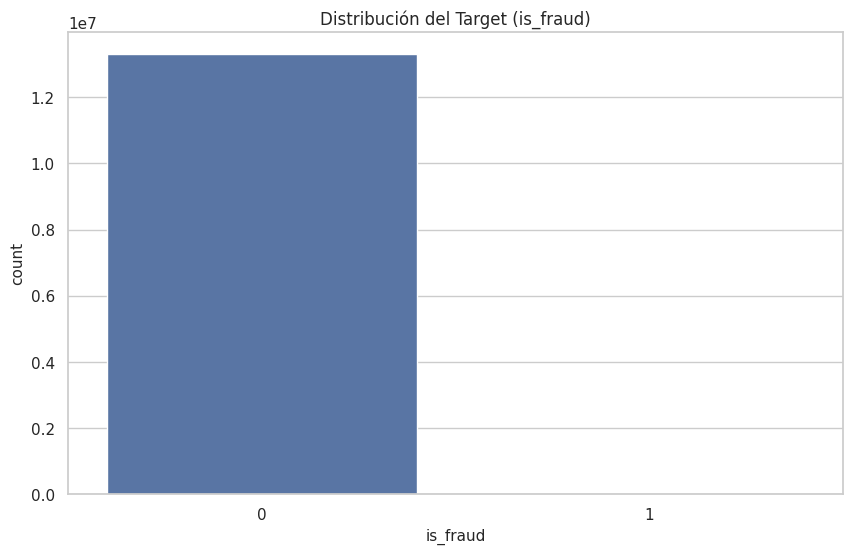


Preview:


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,year,month,day_of_week,hour,is_off_hours,has_error,use_chip_flag,client_id_card,card_brand,card_type,expires,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,account_age_days,is_expired,years_since_pin_change,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,fraud_score,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN,2010,1,4,0,1,0,0,1556,Mastercard,Debit (Prepaid),2022-07-01,1.0,2,55,2008-05-01,2008,0.0,6292,1,17,30,67,1989,7,Female,594 Mountain View Street,46.80,-100.76,NaN,NaN,NaN,740,4,0.0,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN,2010,1,4,0,1,0,0,561,Mastercard,Credit,2024-12-01,1.0,1,9100,2005-09-01,2015,0.0,7265,1,10,48,67,1971,6,Male,604 Pine Street,40.80,-91.12,NaN,NaN,NaN,834,5,0.0,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN,2010,1,4,0,1,0,0,1129,Mastercard,Debit,2020-05-01,1.0,1,14802,2006-01-01,2008,0.0,7143,1,17,49,65,1970,4,Male,2379 Forest Lane,33.18,-117.29,NaN,NaN,NaN,686,3,0.0,0
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN,2010,1,4,0,1,0,0,430,Mastercard,Debit,2024-10-01,0.0,2,37634,2004-05-01,2006,0.0,7753,1,19,52,67,1967,5,Female,903 Hill Boulevard,41.42,-87.35,NaN,NaN,NaN,685,5,0.0,0
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN,2010,1,4,0,1,0,0,848,Visa,Debit,2020-01-01,1.0,1,19113,2009-07-01,2014,0.0,5866,1,11,51,69,1968,5,Male,166 River Drive,38.86,-76.60,NaN,NaN,NaN,711,2,0.0,0


In [ ]:
# ==============================
# 📊 Métricas dinámicas de control (ETL hasta dataset_final_limpio)
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def _mem_mb(df):
    return df.memory_usage(deep=True).sum() / (1024**2)

def _top_nulls(df, k=10):
    return (df.isnull().mean()*100).sort_values(ascending=False).head(k).round(2)

def _dup_count(df, key):
    return df.duplicated(subset=[key]).sum() if key in df.columns else np.nan

def _date_summary(df, col='date'):
    if col not in df.columns:
        return "—", "—", [], []
    d = pd.to_datetime(df[col], errors='coerce')
    dmin, dmax = d.min(), d.max()
    years = sorted(d.dt.year.dropna().unique().tolist())
    months = sorted(d.dt.month.dropna().unique().tolist())
    return dmin, dmax, years, months

print("═══════════════════════════════════════════════════════════════════════")
print("📦 ESTADO DE TABLAS LIMPIAS (SILVER)")
print("═══════════════════════════════════════════════════════════════════════")

# --- Transactions
if 'df_transactions_clean' in globals():
    print("\n[Transactions]")
    print("Dimensiones:", df_transactions_clean.shape, f" | Memoria: {_mem_mb(df_transactions_clean):.2f} MB")
    print("Duplicados por 'id':", _dup_count(df_transactions_clean, 'id'))
    print("Top nulos (%):\n", _top_nulls(df_transactions_clean, 10))
    dmin, dmax, years, months = _date_summary(df_transactions_clean, 'date')
    print(f"Rango de fechas: {dmin} → {dmax}")
    print("Años presentes:", years)
    print("Meses presentes (números 1-12):", months[:20], "..." if len(months) > 20 else "")
else:
    print("\n[Transactions] No encontrada (df_transactions_clean)")

# --- Cards
if 'df_cards_clean' in globals():
    print("\n[Cards]")
    print("Dimensiones:", df_cards_clean.shape, f" | Memoria: {_mem_mb(df_cards_clean):.2f} MB")
    print("Duplicados por 'card_id':", _dup_count(df_cards_clean, 'card_id'))
    print("Top nulos (%):\n", _top_nulls(df_cards_clean, 10))
else:
    print("\n[Cards] No encontrada (df_cards_clean)")

# --- Users
if 'df_users_clean' in globals():
    print("\n[Users]")
    print("Dimensiones:", df_users_clean.shape, f" | Memoria: {_mem_mb(df_users_clean):.2f} MB")
    print("Duplicados por 'user_id':", _dup_count(df_users_clean, 'user_id'))
    print("Top nulos (%):\n", _top_nulls(df_users_clean, 10))
else:
    print("\n[Users] No encontrada (df_users_clean)")

# --- Integridad referencial antes del join
print("\n═══════════════════════════════════════════════════════════════════════")
print("🔗 INTEGRIDAD REFERENCIAL (antes del join)")
print("═══════════════════════════════════════════════════════════════════════")
if 'df_transactions_clean' in globals() and 'df_cards_clean' in globals() and 'card_id' in df_transactions_clean.columns and 'card_id' in df_cards_clean.columns:
    miss_cards = (~df_transactions_clean['card_id'].isin(df_cards_clean['card_id'])).mean()*100
    print(f"% Tx con card_id sin match en Cards: {miss_cards:.2f}%")
else:
    print("No se pudo evaluar card_id (faltan columnas/tablas).")

if 'df_transactions_clean' in globals() and 'df_users_clean' in globals():
    tx_client_col = 'client_id' if 'client_id' in df_transactions_clean.columns else None
    users_client_col = 'user_id' if 'user_id' in df_users_clean.columns else None
    if tx_client_col and users_client_col:
        miss_users = (~df_transactions_clean[tx_client_col].isin(df_users_clean[users_client_col])).mean()*100
        print(f"% Tx con client_id sin match en Users: {miss_users:.2f}%")
    else:
        print("No se pudo evaluar client_id vs user_id (faltan columnas).")
else:
    print("No se pudo evaluar client_id (faltan tablas).")

# --- Dataset final (si ya existe)
print("\n═══════════════════════════════════════════════════════════════════════")
print("🥇 DATASET FINAL (si está disponible en memoria)")
print("═══════════════════════════════════════════════════════════════════════")
if 'df_final' in globals():
    print("Dimensiones:", df_final.shape, f" | Memoria: {_mem_mb(df_final):.2f} MB")
    print("Top nulos (%):\n", _top_nulls(df_final, 10))
    if 'is_fraud' in df_final.columns:
        dist = (df_final['is_fraud'].value_counts(normalize=True)*100).round(2)
        print("\nDistribución is_fraud (%):")
        print(dist)
        # Mini gráfico
        try:
            sns.countplot(x='is_fraud', data=df_final)
            plt.title("Distribución del Target (is_fraud)")
            plt.grid(True, axis='y')
            plt.show()
        except Exception as e:
            print("No se pudo graficar is_fraud:", e)
    else:
        print("No se encuentra la columna 'is_fraud' en df_final.")
    print("\nPreview:")
    display(df_final.head(5))
else:
    print("df_final no está en memoria aún (se verá tras el join Gold).")


# INFORME— Inteligencia de Negocios (BI) para Detección de Fraude

## Objetivo
Entregar una vista ejecutiva del problema de fraude a partir del `dataset_final_limpio.csv`, con KPIs, segmentaciones y visualizaciones que permitan:
- Dimensionar el problema (volumen, tasa, impacto económico).
- Identificar patrones temporales, geográficos y por tipo de comercio (MCC).
- Encontrar segmentos de mayor riesgo para acciones concretas (reglas, step-up, límites dinámicos).
- Preparar insumos para el modelo ML y el dashboard (Power BI / Streamlit).

## Supuestos y notas
- `is_fraud` proviene de una **heurística ponderada**:  
  `fraud_score = 0.5*(amount>3000) + 0.3*card_on_dark_web + 0.2*has_error`  
  `is_fraud = 1(fraud_score >= 0.5)`
- Columnas esperadas (principales):  
  `is_fraud, amount, date, year, month, day_of_week, hour, merchant_city, merchant_state, mcc, use_chip_flag, has_error, card_on_dark_web, credit_limit, account_age_days`.
- Calidad de datos: normalización de montos, fechas, flags; corrección de lat/long; deduplicación por PK; unión `tx→cards→users`.

## KPIs (definiciones)
- **Total Transacciones**: conteo de filas.  
- **Total Fraudes**: conteo de filas con `is_fraud=1`.  
- **Tasa de Fraude**: `Total Fraudes / Total Transacciones`.  
- **Monto Defraudado**: suma de `amount` cuando `is_fraud=1`.  
- **Ticket Medio (fraude/no fraude)**: promedio de `amount` por clase.

## Segmentaciones y vistas
- **Temporal**: por `year/month`, `day_of_week`, `hour` (estacionalidad y off-hours).
- **Geográfica**: por `merchant_city` / `merchant_state`.
- **MCC**: giros de comercio con mayores tasas/volúmenes de fraude.
- **Señales**: `use_chip_flag`, `has_error`, `card_on_dark_web`.

## Entregables de esta sección
- Tabla de KPIs ejecutivos.
- Tablas segmentadas (mes, ciudad, MCC, hora/día).
- Visuales clave: tendencia mensual, heatmap horario, top ciudades/MCC, comparativas de flags.
- Lista de decisiones y recomendaciones operativas.

---

## Calculos para Negocio y KPIs ##

In [ ]:
# ==============================
# 📌 CÁLCULOS DE NEGOCIO (KPIs y segmentaciones)
# Requiere: df_final ya cargado en memoria
# ==============================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if df_final exists in memory, if not, load it
if 'df_final' not in globals():
    try:
        df_final = pd.read_csv('/content/dataset_final_limpio.csv')
        print("✅ df_final cargado desde /content/dataset_final_limpio.csv")
    except FileNotFoundError:
        print("❌ Error: dataset_final_limpio.csv no encontrado en /content/. Asegúrate de haberlo generado o descargado.")
        raise # Re-raise the error if the file isn't found

assert 'df_final' in globals(), "df_final no está en memoria después del intento de carga."


# ---- Normalizaciones suaves (por si falta algo) ----
if 'date' in df_final.columns and (('year' not in df_final.columns) or ('month' not in df_final.columns)):
    d = pd.to_datetime(df_final['date'], errors='coerce')
    df_final['year'] = d.dt.year
    df_final['month'] = d.dt.month
    df_final['day_of_week'] = d.dt.dayofweek
    df_final['hour'] = d.dt.hour

# Montos y clases
df_final['amount'] = pd.to_numeric(df_final['amount'], errors='coerce')
df_final['is_fraud'] = pd.to_numeric(df_final['is_fraud'], errors='coerce').fillna(0).astype(int)

# ==============================
# KPIs ejecutivos
# ==============================
tot_tx = len(df_final)
tot_fraudes = df_final['is_fraud'].sum()
tasa_fraude = (tot_fraudes / tot_tx) if tot_tx else 0.0
monto_total = df_final['amount'].sum(skipna=True)
monto_fraude = df_final.loc[df_final['is_fraud']==1, 'amount'].sum(skipna=True)

kpis = {
    'total_transacciones': int(tot_tx),
    'total_fraudes': int(tot_fraudes),
    'tasa_fraude_pct': round(100*tasa_fraude, 2),
    'monto_total': float(monto_total),
    'monto_defraudado': float(monto_fraude),
    'ticket_medio_fraude': float(df_final.loc[df_final['is_fraud']==1, 'amount'].mean(skipna=True)),
    'ticket_medio_no_fraude': float(df_final.loc[df_final['is_fraud']==0, 'amount'].mean(skipna=True)),
}
kpis_df = pd.DataFrame([kpis])
print("✅ KPIs ejecutivos:"); display(kpis_df)

# ==============================
# Tendencia mensual
# ==============================
if {'year','month','is_fraud'}.issubset(df_final.columns):
    by_month = (
        df_final
        .groupby(['year','month'], as_index=False)
        .agg(tx=('is_fraud','count'),
             fraudes=('is_fraud','sum'),
             tasa=('is_fraud','mean'),
             monto_fraude=('amount', lambda s: s[df_final.loc[s.index,'is_fraud']==1].sum()))
        .sort_values(['year','month'])
    )
else:
    by_month = pd.DataFrame()
print("📈 Tendencia mensual (primeras filas):"); display(by_month.head(12))

# ==============================
# Top ciudades (conteo, tasa, monto)
# ==============================
if 'merchant_city' in df_final.columns:
    by_city = (
        df_final
        .groupby('merchant_city', as_index=False)
        .agg(tx=('is_fraud','count'),
             fraudes=('is_fraud','sum'),
             tasa=('is_fraud','mean'),
             monto_fraude=('amount', lambda s: s[df_final.loc[s.index,'is_fraud']==1].sum()))
        .query('tx >= 100')  # umbral para robustez (ajustable)
        .sort_values(['fraudes','tasa'], ascending=[False, False])
    )
else:
    by_city = pd.DataFrame()
print("🏙️ Top ciudades (primeras filas):"); display(by_city.head(20))

# ==============================
# Top MCC (conteo, tasa, monto)
# ==============================
if 'mcc' in df_final.columns:
    by_mcc = (
        df_final
        .groupby('mcc', as_index=False)
        .agg(tx=('is_fraud','count'),
             fraudes=('is_fraud','sum'),
             tasa=('is_fraud','mean'),
             monto_fraude=('amount', lambda s: s[df_final.loc[s.index,'is_fraud']==1].sum()))
        .query('tx >= 200')  # umbral para robustez (ajustable)
        .sort_values(['fraudes','tasa'], ascending=[False, False])
    )
else:
    by_mcc = pd.DataFrame()
print("🏬 Top MCC (primeras filas):"); display(by_mcc.head(20))

# ==============================
# Hora y día de la semana
# ==============================
by_hour = (
    df_final.groupby('hour')['is_fraud']
    .agg(tx='count', fraudes='sum', tasa='mean')
    .reset_index()
    if 'hour' in df_final.columns else pd.DataFrame()
)
by_dow = (
    df_final.groupby('day_of_week')['is_fraud']
    .agg(tx='count', fraudes='sum', tasa='mean')
    .reset_index()
    if 'day_of_week' in df_final.columns else pd.DataFrame()
)
print("🕒 Por hora (primeras filas):"); display(by_hour.head())
print("📅 Por día de semana (0=Lunes):"); display(by_dow.head())

# ==============================
# Señales: chip / errores / dark web
# ==============================
def _agg_flag(col):
    if col not in df_final.columns:
        return pd.DataFrame()
    return (
        df_final.groupby(col)['is_fraud']
        .agg(tx='count', fraudes='sum', tasa='mean')
        .reset_index()
        .sort_values('tasa', ascending=False)
    )

chip_tbl = _agg_flag('use_chip_flag')
err_tbl  = _agg_flag('has_error')
dark_tbl = _agg_flag('card_on_dark_web')

print("💳 Chip vs Swipe:"); display(chip_tbl)
print("⚠️ Errores en transacción:"); display(err_tbl)
print("🕶️ Tarjeta en dark web:"); display(dark_tbl)

# ==============================
# (Opcional) Correlaciones rápidas con is_fraud
# ==============================
num_cols = df_final.select_dtypes(include=np.number).columns.tolist()
if 'is_fraud' in num_cols:
    corr = df_final[num_cols].corr(numeric_only=True)['is_fraud'].sort_values(ascending=False)
    print("🔗 Correlaciones numéricas con is_fraud:")
    display(corr.head(15))

## Visualizaciones Claves de Negocio ##

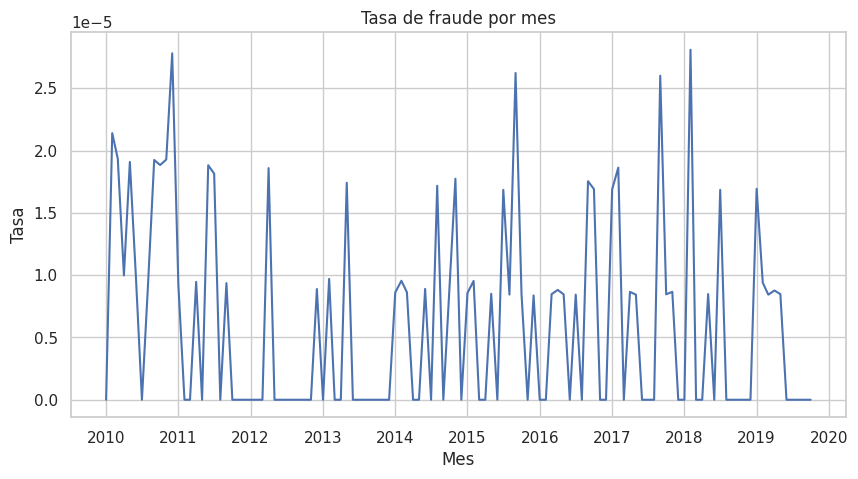

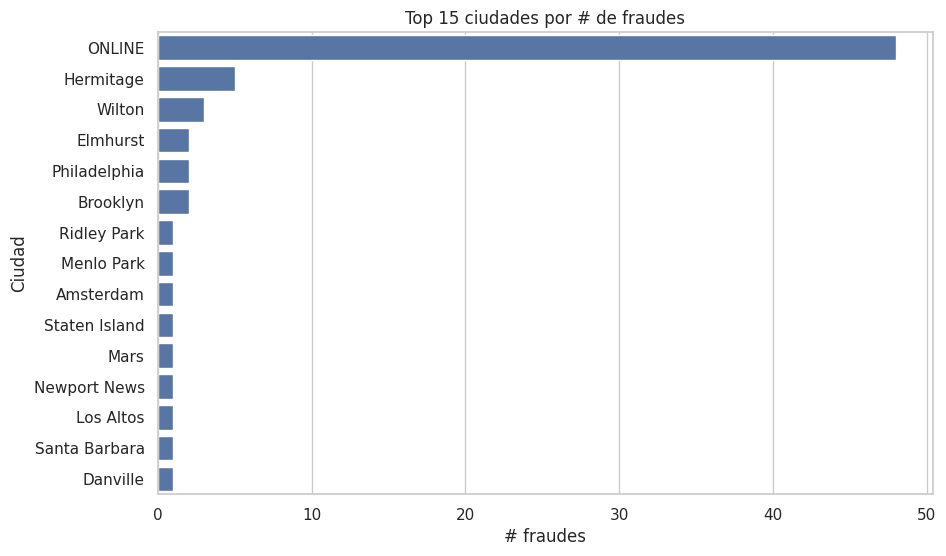

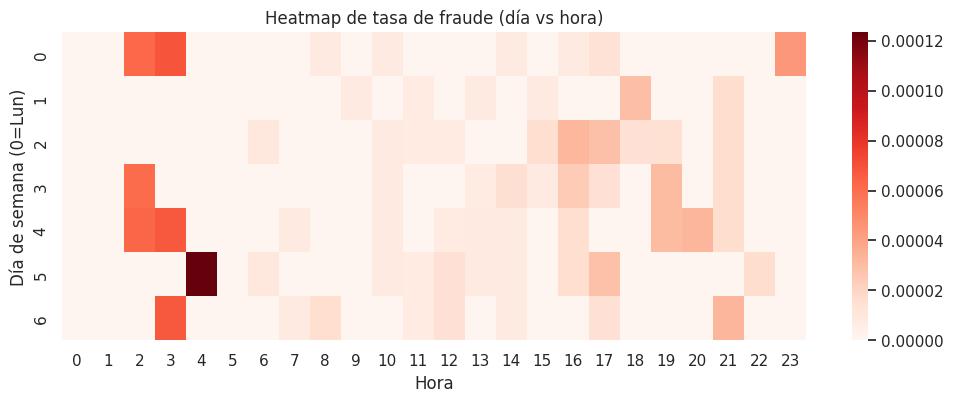

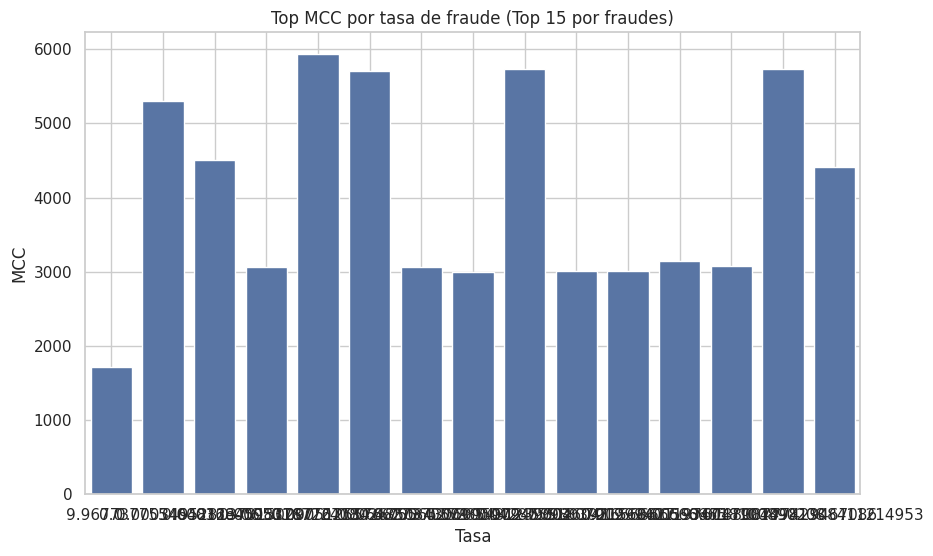

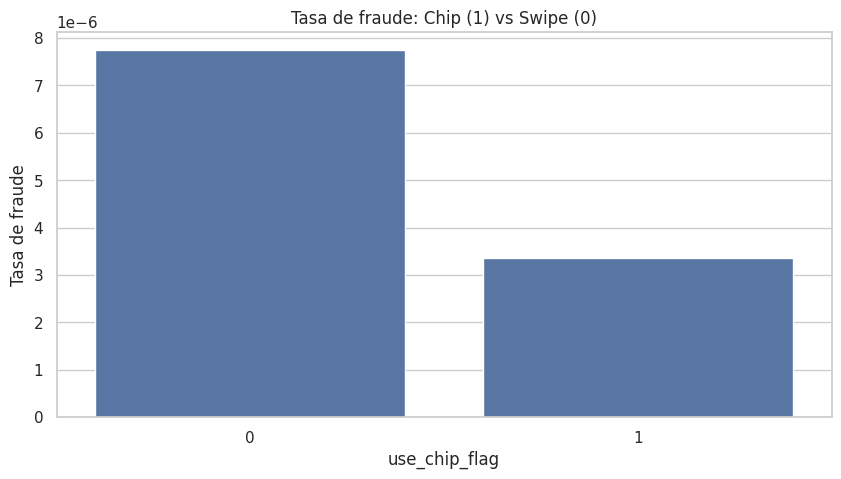

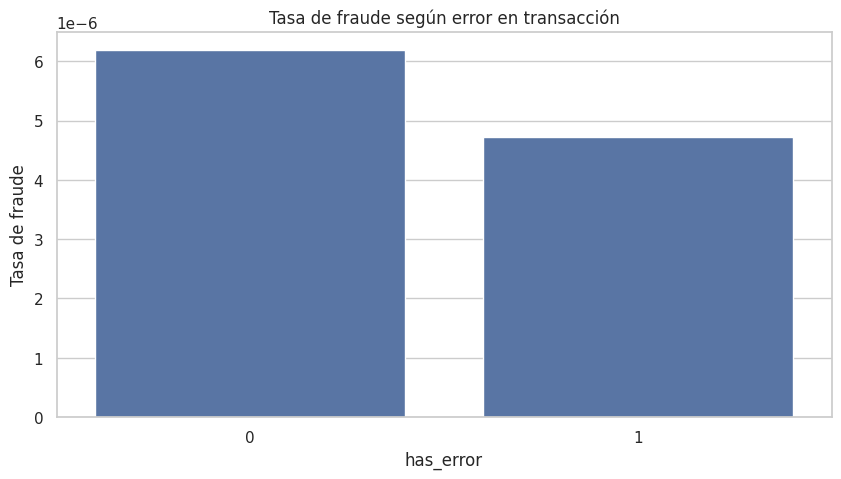

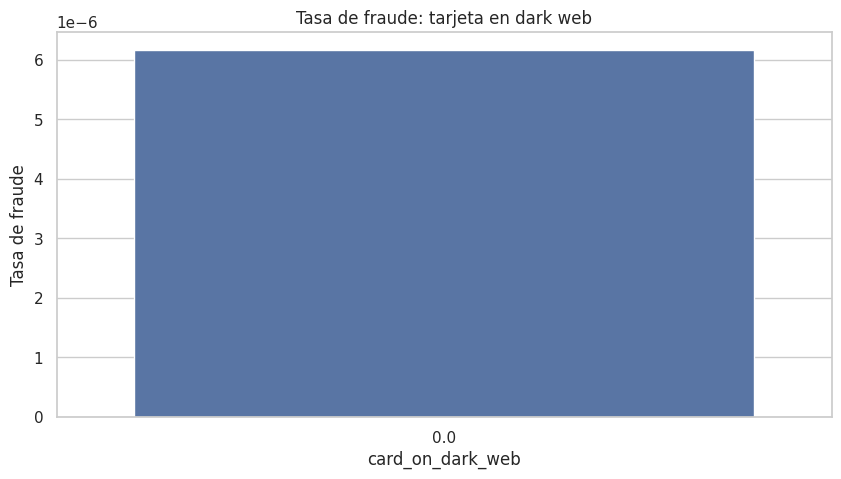

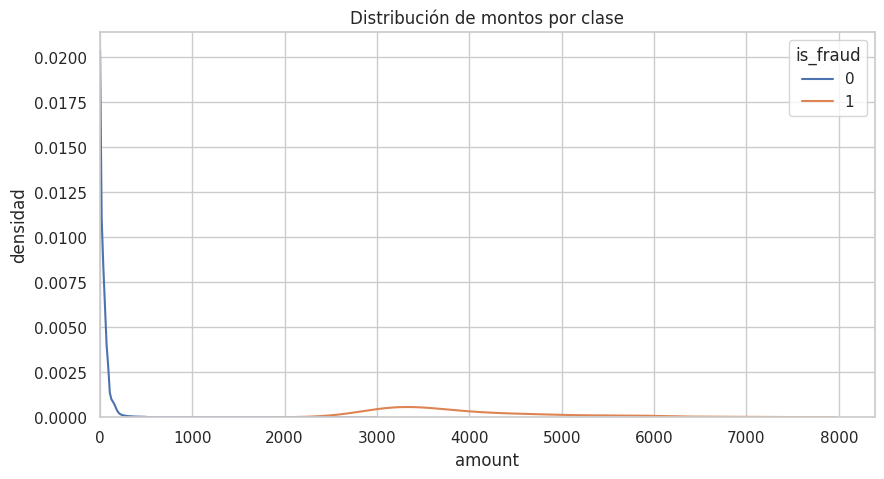

In [ ]:
# ==============================
# 📈 VISUALIZACIONES CLAVE
# ==============================
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# 1) Tasa de fraude mensual
if 'by_month' in globals() and not by_month.empty:
    by_month_plot = by_month.copy()
    by_month_plot['period'] = pd.to_datetime(by_month_plot['year'].astype(str) + '-' + by_month_plot['month'].astype(str) + '-01')
    plt.figure()
    sns.lineplot(data=by_month_plot, x='period', y='tasa')
    plt.title('Tasa de fraude por mes'); plt.xlabel('Mes'); plt.ylabel('Tasa')
    plt.grid(True); plt.show()

# 2) Top 15 ciudades por fraudes (conteo)
if 'by_city' in globals() and not by_city.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=by_city.head(15), x='fraudes', y='merchant_city')
    plt.title('Top 15 ciudades por # de fraudes'); plt.xlabel('# fraudes'); plt.ylabel('Ciudad')
    plt.grid(True, axis='x'); plt.show()

# 3) Heatmap día vs hora (tasa)
if {'day_of_week','hour','is_fraud'}.issubset(df_final.columns):
    pivot = df_final.pivot_table(index='day_of_week', columns='hour', values='is_fraud', aggfunc='mean')
    plt.figure(figsize=(12, 4))
    sns.heatmap(pivot, cmap='Reds')
    plt.title('Heatmap de tasa de fraude (día vs hora)'); plt.xlabel('Hora'); plt.ylabel('Día de semana (0=Lun)')
    plt.show()

# 4) Tasa por MCC (Top 15 por fraudes)
if 'by_mcc' in globals() and not by_mcc.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=by_mcc.head(15), x='tasa', y='mcc')
    plt.title('Top MCC por tasa de fraude (Top 15 por fraudes)'); plt.xlabel('Tasa'); plt.ylabel('MCC')
    plt.grid(True, axis='x'); plt.show()

# 5) Comparativa de flags (chip/errores/dark web)
def plot_flag(tbl, title, xlab):
    if tbl is None or tbl.empty:
        return
    plt.figure()
    # Si la columna es {0,1} forzamos el orden 1,0 para ver claramente el "caso de interés"
    if 1 in tbl.iloc[:,0].values and 0 in tbl.iloc[:,0].values:
        tbl_sorted = tbl.set_index(tbl.columns[0]).loc[[1,0]].reset_index()
    else:
        tbl_sorted = tbl.sort_values('tasa', ascending=False)
    sns.barplot(data=tbl_sorted, x=tbl_sorted.columns[0], y='tasa')
    plt.title(title); plt.xlabel(xlab); plt.ylabel('Tasa de fraude')
    plt.grid(True, axis='y'); plt.show()

plot_flag(chip_tbl, 'Tasa de fraude: Chip (1) vs Swipe (0)', 'use_chip_flag')
plot_flag(err_tbl, 'Tasa de fraude según error en transacción', 'has_error')
plot_flag(dark_tbl, 'Tasa de fraude: tarjeta en dark web', 'card_on_dark_web')

# 6) Distribución de montos por clase (opcional)
if {'amount','is_fraud'}.issubset(df_final.columns):
    plt.figure()
    sns.kdeplot(data=df_final, x='amount', hue='is_fraud', common_norm=False)
    plt.title('Distribución de montos por clase'); plt.xlabel('amount'); plt.ylabel('densidad')
    plt.xlim(left=0)  # evita montos negativos en la vista
    plt.grid(True); plt.show()


# Desiciones y Recomendaciones de negocio #


## 1) Reglas operativas inmediatas
- **Step-up (OTP / 2FA)** para transacciones con **monto > X** y en **horarios off-hours** (0–5 y 23 h).
- **Forzar chip (EMV)** o declinar **swipe** en **MCC con alta tasa** (ver Top MCC).
- **Lista de control para Dark Web**: si `card_on_dark_web=1`, elevar la exigencia de validación (device + OTP + CVV dinámico).

## 2) Límites y políticas dinámicas
- Reducir el **límite de autorización** en segmentos de alto riesgo (ciudades/MCC/horas críticas).
- Incrementar límites en segmentos con **bajo riesgo** para mejorar conversión y UX.

## 3) Monitoreo y alertas
- **Alertas semanales** de: tasa de fraude por mes, top ciudades, top MCC, horas de mayor incidencia.
- **Panel operativo** con watchlist de comerciantes/ciudades + drill-down a transacciones.

## 4) Estrategia de costos (umbral por costo en el modelo)
- Ajustar el umbral de decisión según **C_FP** (falso positivo) vs **C_FN** (falso negativo).
- Implementar **triple estado**: `OK`, `REVISAR`, `ALTO_RIESGO` para balancear fricción y pérdida.

## 5) Calidad de datos y next steps
- Completar/validar **lat/long y ciudad** del comerciante; asegurar formato robusto.
- Revisar outliers en `amount` y valores extremos de `credit_limit`.
- Agregar señales de **dispositivo/IP**, **historial del cliente**, y **features secuenciales** (ventanas móviles).

> Estas acciones deben traducirse a reglas en producción, modelado con umbral por costo, y tableros con objetivos (KPI) y *alerts* para seguimiento continuo.


# Pipeline para ML/ Desarrollo de algoritmos para ML #


Qué hace este pipeline

Usa ColumnTransformer para imputación/escala (numéricas) y OHE (categóricas).

Entrena y evalúa dos baselines (LogReg y RandomForest) con CV (PR AUC).

Si está disponible, hace RandomizedSearchCV sobre LightGBM y lo compara contra los baselines.

Selecciona el mejor modelo, evalúa en holdout, calcula umbral por costo (C_FN ≫ C_FP) y define un doble umbral (best_thr, thr_high) para triage.

Exporta artefactos listos para Streamlit/producción.

In [ ]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.0 MB/s eta 0:00:00


In [ ]:
# ============================================================
# 🧠 PIPELINE CON CHECKPOINTS + PROGRESO (Baselines + LGBM manual)
#    - Guarda avances en Google Drive
#    - Reanuda si se corta la sesión (omite lo ya hecho)
#    - Barra de progreso en tiempo real
# ============================================================

import os, json, joblib, warnings, logging, time, hashlib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ─────────────────────────────────────────────────────────────
# 0) Montar Drive (si estás en Colab) y definir rutas persistentes
# ─────────────────────────────────────────────────────────────
try:
    from google.colab import drive  # type: ignore
    DRIVE_MODE = True
except Exception:
    DRIVE_MODE = False

if DRIVE_MODE:
    drive.mount('/content/drive', force_remount=False)
    BASE_DIR = '/content/drive/MyDrive/Proyecto_Fraude'
else:
    BASE_DIR = './Proyecto_Fraude_local'  # fallback local

ART_DIR = os.path.join(BASE_DIR, "artifacts_v5")   # ⇐ Cambié a v5 para no pisar v4
os.makedirs(ART_DIR, exist_ok=True)

BASELINES_CSV = os.path.join(ART_DIR, "baselines_results.csv")
SEARCH_CSV    = os.path.join(ART_DIR, "lgbm_search_results.csv")
BEST_MODEL_PKL= os.path.join(ART_DIR, "best_so_far.pkl")
BEST_PARAMS_JS= os.path.join(ART_DIR, "best_params.json")
METRICS_SUM   = os.path.join(ART_DIR, "metrics_summary.csv")
THR_SENS_CSV  = os.path.join(ART_DIR, "threshold_sensitivity.csv")
THRESHOLDS_JS = os.path.join(ART_DIR, "thresholds.json")
PROGRESS_JS   = os.path.join(ART_DIR, "progress.json")

# ─────────────────────────────────────────────────────────────
# Utils
# ─────────────────────────────────────────────────────────────
from tqdm.auto import tqdm

def save_json(path, obj):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as f:
        json.dump(obj, f, indent=2)

def append_csv(path, row_dict):
    df = pd.DataFrame([row_dict])
    header = not os.path.exists(path)
    df.to_csv(path, mode='a', header=header, index=False)

def hash_params(d: dict) -> str:
    """Tag estable para un dict de hiperparámetros (para reanudar sin repetir)."""
    s = json.dumps(d, sort_keys=True)
    return hashlib.md5(s.encode()).hexdigest()

def update_progress(stage:str, detail:str=None, pct:float=None):
    payload = {'stage': stage, 'detail': detail, 'pct': None if pct is None else float(pct), 'ts': time.time()}
    save_json(PROGRESS_JS, payload)

# ─────────────────────────────────────────────────────────────
# 1) Cargar dataset final (o leer si ya lo tienes en memoria)
# ─────────────────────────────────────────────────────────────
if 'df_final' not in globals():
    df_final = pd.read_csv('/content/dataset_final_limpio.csv')

TARGET = 'is_fraud'
drop_cols = [c for c in ['is_fraud','transaction_id','user_id','card_id','id','client_id'] if c in df_final.columns]
X = df_final.drop(columns=drop_cols, errors='ignore')
y = df_final[TARGET].astype(int)

# Evitar explosión de OHE con columnas de alta cardinalidad / fechas crudas
high_cardinality_cols = ['merchant_city', 'merchant_state', 'address', 'date', 'expires', 'acct_open_date']
X = X.drop(columns=[c for c in high_cardinality_cols if c in X.columns], errors='ignore')

# Tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

# Preprocesamiento
numeric_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categorical_tf, cat_cols)
], remainder='drop')

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ─────────────────────────────────────────────────────────────
# 2) Baselines con progreso y guardado incremental
# ─────────────────────────────────────────────────────────────
from sklearn.base import clone

def cv_eval_with_progress(pipe, X, y, cv, metric='ap', pbar=None):
    """CV manual con barra de progreso y guarda por fold (retorna promedio)."""
    skf = cv
    scores = []
    for i, (tr, va) in enumerate(skf.split(X, y), start=1):
        model = clone(pipe)
        model.fit(X.iloc[tr], y.iloc[tr])
        proba = model.predict_proba(X.iloc[va])[:,1]
        ap = average_precision_score(y.iloc[va], proba)
        roc = roc_auc_score(y.iloc[va], proba)
        scores.append((ap, roc))
        if pbar is not None:
            pbar.update(1)
    ap_mean = float(np.mean([s[0] for s in scores]))
    roc_mean= float(np.mean([s[1] for s in scores]))
    return ap_mean, roc_mean

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baselines = {
    "logreg_bal": LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1 if hasattr(LogisticRegression, 'n_jobs') else None),
    "rf_bal": RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        class_weight='balanced', n_jobs=-1, random_state=42
    )
}

print("\n▶ Baselines (con progreso y guardado incremental)")
if os.path.exists(BASELINES_CSV):
    done_baselines = set(pd.read_csv(BASELINES_CSV)['model'].tolist())
else:
    done_baselines = set()

baseline_rows = []
total_folds = len(baselines) * cv.get_n_splits()
with tqdm(total=total_folds, desc="CV baselines", leave=True) as pbar:
    for name, est in baselines.items():
        if name in done_baselines:
            # Recuperar y no repetir
            print(f"⏭️ Ya evaluado: {name}")
            pbar.update(cv.get_n_splits())
            continue

        pipe = Pipeline([('prep', preprocess), ('clf', est)])
        ap_mean, roc_mean = cv_eval_with_progress(pipe, X_train, y_train, cv, pbar=pbar)
        row = {"model": name, "ap": ap_mean, "roc_auc": roc_mean}
        append_csv(BASELINES_CSV, row)
        baseline_rows.append(row)
        update_progress(stage="baselines", detail=name)

# Consolidar resultados
if os.path.exists(BASELINES_CSV):
    results_df = pd.read_csv(BASELINES_CSV).sort_values('ap', ascending=False)
else:
    results_df = pd.DataFrame(baseline_rows).sort_values('ap', ascending=False)

print("\n📋 Resultados CV (Baselines) — ordenados por AP:")
display(results_df)

best_baseline_name = results_df.iloc[0]['model']
best_baseline_est  = baselines[best_baseline_name]
best_cv_ap_baseline= float(results_df.iloc[0]['ap'])

# ─────────────────────────────────────────────────────────────
# 3) Búsqueda LGBM manual con reanudación y progreso
# ─────────────────────────────────────────────────────────────
LGBM_AVAILABLE = False
try:
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True
except Exception as e:
    print("⚠️ LightGBM no está disponible. Instálalo si deseas usarlo: !pip install lightgbm")

best_label = best_baseline_name
best_model = Pipeline([('prep', preprocess), ('clf', best_baseline_est)])
best_model.fit(X_train, y_train)
best_cv_ap = best_cv_ap_baseline
save_json(BEST_PARAMS_JS, {"model": best_label, "note": "baseline"})
joblib.dump(best_model, BEST_MODEL_PKL)

if LGBM_AVAILABLE:
    # Param spaces (puedes ajustar rangos)
    rng = np.random.RandomState(42)
    N_ITER = 25
    candidates = []
    for _ in range(N_ITER):
        cand = {
            'n_estimators': int(rng.randint(200, 600)),
            'max_depth': int(rng.randint(3, 20)),
            'num_leaves': int(rng.randint(15, 63)),
            'min_child_samples': int(rng.randint(10, 200)),
            'subsample': float(rng.uniform(0.7, 1.0)),
            'colsample_bytree': float(rng.uniform(0.7, 1.0)),
            'learning_rate': float(rng.uniform(0.01, 0.1)),
        }
        cand['tag'] = hash_params(cand)
        candidates.append(cand)

    # Reanudar: omitir tags ya corridos
    done_tags = set()
    if os.path.exists(SEARCH_CSV):
        try:
            prev = pd.read_csv(SEARCH_CSV)
            if 'tag' in prev.columns:
                done_tags = set(prev['tag'].tolist())
        except Exception:
            pass

    # Progreso: total = #candidatos * folds
    folds = cv.get_n_splits()
    total_steps = sum(1 for c in candidates if c['tag'] not in done_tags) * folds

    print("\n▶ Tuning LGBM (manual, con progreso + checkpoint por candidato)")
    with tqdm(total=total_steps, desc="CV LGBM candidates", leave=True) as pbar_cand:
        for cand in candidates:
            if cand['tag'] in done_tags:
                pbar_cand.update(folds)
                continue

            # Construir pipeline por candidato
            lgbm = LGBMClassifier(
                random_state=42, class_weight='balanced',
                n_estimators=cand['n_estimators'],
                learning_rate=cand['learning_rate'],
                subsample=cand['subsample'],
                colsample_bytree=cand['colsample_bytree'],
                max_depth=cand['max_depth'],
                num_leaves=cand['num_leaves'],
                min_child_samples=cand['min_child_samples'],
                n_jobs=-1
            )
            pipe = Pipeline([('prep', preprocess), ('clf', lgbm)])

            # CV manual con progreso
            aps, rocs = [], []
            for i, (tr, va) in enumerate(cv.split(X_train, y_train), start=1):
                model = Pipeline([('prep', preprocess), ('clf', lgbm)])
                # Tip: puedes pasar early stopping en la API sklearn con kwargs:
                # model.fit(X_train.iloc[tr], y_train.iloc[tr],
                #           clf__eval_set=[(X_train.iloc[va], y_train.iloc[va])],
                #           clf__eval_metric=['auc','average_precision'],
                #           clf__early_stopping_rounds=100)
                model.fit(X_train.iloc[tr], y_train.iloc[tr])
                proba = model.predict_proba(X_train.iloc[va])[:,1]
                aps.append(average_precision_score(y_train.iloc[va], proba))
                rocs.append(roc_auc_score(y_train.iloc[va], proba))
                pbar_cand.update(1)

            ap_mean = float(np.mean(aps))
            roc_mean= float(np.mean(rocs))

            # Guardar fila de resultados del candidato
            append_csv(SEARCH_CSV, {
                'tag': cand['tag'], **{k:v for k,v in cand.items() if k!='tag'},
                'ap': ap_mean, 'roc_auc': roc_mean
            })
            update_progress(stage="lgbm_search", detail=cand['tag'])

            # Si mejora, guardamos "mejor hasta ahora"
            if ap_mean > best_cv_ap:
                best_cv_ap = ap_mean
                best_label = f"lgbm_{cand['tag']}"
                # Entrenar con TODO el train y guardar pipeline
                best_model = Pipeline([('prep', preprocess), ('clf', lgbm)])
                best_model.fit(X_train, y_train)
                joblib.dump(best_model, BEST_MODEL_PKL)
                save_json(BEST_PARAMS_JS, {"model": best_label, **cand})
                print(f"🟢 Nuevo mejor AP (CV): {best_cv_ap:.4f} | tag={cand['tag']} (checkpoint guardado)")

# ─────────────────────────────────────────────────────────────
# 4) Evaluación holdout + umbral por costo + guardado final
# ─────────────────────────────────────────────────────────────
print(f"\n🏆 Modelo seleccionado: {best_label}")
y_prob = best_model.predict_proba(X_test)[:, 1]
ap_holdout = float(average_precision_score(y_test, y_prob))
roc_holdout= float(roc_auc_score(y_test, y_prob))
print(f"Holdout — PR AUC: {ap_holdout:.4f} | ROC AUC: {roc_holdout:.4f}")

def find_cost_threshold(y_true, y_prob, C_FP=1.0, C_FN=10.0, grid=np.linspace(0.05, 0.95, 181)):
    from sklearn.metrics import confusion_matrix
    best_thr, best_cost = 0.5, float('inf')
    details = []
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = C_FP*fp + C_FN*fn
        details.append((t, tn, fp, fn, tp, cost))
        if cost < best_cost:
            best_cost, best_thr = cost, t
    return best_thr, best_cost, pd.DataFrame(details, columns=['thr','tn','fp','fn','tp','cost'])

C_FP, C_FN = 1.0, 10.0
best_thr, best_cost, thr_table = find_cost_threshold(y_test, y_prob, C_FP=C_FP, C_FN=C_FN)
thr_high = min(0.95, best_thr + 0.10)

# Reporte a umbral de costo
y_pred = (y_prob >= best_thr).astype(int)
print("\n🔍 Reporte @best_thr")
print(classification_report(y_test, y_pred))
print("Matriz de confusión @best_thr")
print(confusion_matrix(y_test, y_pred))

# Guardar artefactos finales
pd.DataFrame([{
    'cv_ap': float(best_cv_ap),
    'holdout_ap': float(ap_holdout),
    'holdout_roc': float(roc_holdout),
    'best_thr': float(best_thr),
    'thr_high': float(thr_high),
    'C_FP': float(C_FP),
    'C_FN': float(C_FN),
    'model_label': best_label
}]).to_csv(METRICS_SUM, index=False)

thr_table.to_csv(THR_SENS_CSV, index=False)
save_json(THRESHOLDS_JS, {'best_thr': float(best_thr), 'thr_high': float(thr_high), 'C_FP': C_FP, 'C_FN': C_FN})

print("\n✅ Artefactos guardados en:", ART_DIR)
print(" - baselines_results.csv")
print(" - lgbm_search_results.csv")
print(" - best_so_far.pkl")
print(" - best_params.json")
print(" - metrics_summary.csv")
print(" - threshold_sensitivity.csv")
print(" - thresholds.json")
update_progress(stage="done", detail="ok", pct=100.0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Numéricas: 32 | Categóricas: 5

▶ Baselines (con progreso y guardado incremental)


CV baselines:   0%|          | 0/10 [00:00<?, ?it/s]

⏭️ Ya evaluado: logreg_bal
⏭️ Ya evaluado: rf_bal

📋 Resultados CV (Baselines) — ordenados por AP:


,model,ap,roc_auc
0,logreg_bal,1.0,1.0
1,rf_bal,1.0,1.0



▶ Tuning LGBM (manual, con progreso + checkpoint por candidato)


CV LGBM candidates:   0%|          | 0/45 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training becaus

Auditoria rapida de fuga

In [ ]:
# ===== Auditoría de fuga de información (label leakage) =====
import numpy as np
import pandas as pd

assert 'df_final' in globals(), "Carga df_final antes."

# Reconstituir la regla que usaste para el target (ajusta si cambió)
rule = (
    0.5 * (df_final['amount'] > 3000).astype(int)
    + 0.3 * df_final['card_on_dark_web'].fillna(0)
    + 0.2 * df_final['has_error']
)
y_rule = (rule >= 0.5).astype(int)

y = df_final['is_fraud'].astype(int)
mismatch = (y_rule != y).mean()

print(f"⚠️ Porcentaje de filas donde is_fraud != regla: {mismatch:.4%}")
print("Si esto es ~0%, tu etiqueta es (casi) la regla => cualquier modelo que use esas columnas alcanzará ~1.0.")

# Correlaciones brutas con el target (señales de fuga)
cand_cols = [c for c in ['amount','has_error','card_on_dark_web','fraud_score'] if c in df_final.columns]
for c in cand_cols:
    corr = np.corrcoef(df_final[c].fillna(0).values, y.values)[0,1] if df_final[c].dtype != 'O' else np.nan
    print(f"{c:>18}: corr≈{corr:.4f}")


⚠️ Porcentaje de filas donde is_fraud != regla: 0.0000%
Si esto es ~0%, tu etiqueta es (casi) la regla => cualquier modelo que use esas columnas alcanzará ~1.0.
            amount: corr≈0.1173
         has_error: corr≈-0.0001
  card_on_dark_web: corr≈nan
       fraud_score: corr≈0.0495


In [ ]:
# ============================================================
# PIPELINE "SIN FUGA" + PROGRESO + REANUDACIÓN (Baselines)
# ============================================================
import os, json, joblib, warnings, logging, time, hashlib
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ─────────────────────────────────────────────────────────────
# 0) Montar Drive (Colab) y rutas persistentes
# ─────────────────────────────────────────────────────────────
try:
    from google.colab import drive  # type: ignore
    DRIVE_MODE = True
except Exception:
    DRIVE_MODE = False

if DRIVE_MODE:
    drive.mount('/content/drive', force_remount=False)
    BASE_DIR = '/content/drive/MyDrive/Proyecto_Fraude'
else:
    BASE_DIR = './Proyecto_Fraude_local'

ART_DIR = os.path.join(BASE_DIR, "artifacts_noleak_v1")
os.makedirs(ART_DIR, exist_ok=True)

BASELINES_CSV   = os.path.join(ART_DIR, "baselines_results.csv")
BEST_MODEL_PKL  = os.path.join(ART_DIR, "best_so_far.pkl")
BEST_PARAMS_JS  = os.path.join(ART_DIR, "best_params.json")
METRICS_SUM     = os.path.join(ART_DIR, "metrics_summary.csv")
THR_SENS_CSV    = os.path.join(ART_DIR, "threshold_sensitivity.csv")
THRESHOLDS_JS   = os.path.join(ART_DIR, "thresholds.json")
PROGRESS_JS     = os.path.join(ART_DIR, "progress.json")

def save_json(path, obj):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'w') as f:
        json.dump(obj, f, indent=2)

def append_csv(path, row_dict):
    df = pd.DataFrame([row_dict])
    header = not os.path.exists(path)
    df.to_csv(path, mode='a', header=header, index=False)

def update_progress(stage:str, detail:str=None, pct:float=None):
    payload = {'stage': stage, 'detail': detail, 'pct': None if pct is None else float(pct), 'ts': time.time()}
    save_json(PROGRESS_JS, payload)

# ─────────────────────────────────────────────────────────────
# 1) Cargar dataset final limpio
# ─────────────────────────────────────────────────────────────
DATASET = '/content/dataset_final_limpio.csv'
if 'df_final' not in globals():
    df_final = pd.read_csv(DATASET)

# Auditoría mínima (opcional)
assert 'is_fraud' in df_final.columns, "is_fraud no está en el dataset."

# ─────────────────────────────────────────────────────────────
# 2) Evitar fuga: quitar columnas que definen la etiqueta
# ─────────────────────────────────────────────────────────────
TARGET = 'is_fraud'
leak_cols = [c for c in ['fraud_score','has_error','card_on_dark_web'] if c in df_final.columns]
drop_id   = [c for c in ['is_fraud','transaction_id','user_id','card_id','id'] if c in df_final.columns]

df = df_final.drop_duplicates().copy()
y_all = df[TARGET].astype(int)
X_all = df.drop(columns=drop_id + leak_cols, errors='ignore')

# Alta cardinalidad / fechas crudas que podrían explotar OHE (ajusta según tu caso)
to_drop_high_card = [c for c in ['merchant_city','merchant_state','address','date','expires','acct_open_date'] if c in X_all.columns]
X_all = X_all.drop(columns=to_drop_high_card, errors='ignore')

# ─────────────────────────────────────────────────────────────
# 3) Split por cliente (evita contaminación de identidad)
# ─────────────────────────────────────────────────────────────
groups = df['client_id'] if 'client_id' in df.columns else np.arange(len(df))
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups))

X_train, X_test = X_all.iloc[tr_idx], X_all.iloc[te_idx]
y_train, y_test = y_all.iloc[tr_idx], y_all.iloc[te_idx]
groups_train    = groups.iloc[tr_idx] if hasattr(groups, 'iloc') else groups[tr_idx]

print("Distribución y_train:", y_train.value_counts(normalize=True).to_dict())
print("Distribución y_test :", y_test.value_counts(normalize=True).to_dict())

# ─────────────────────────────────────────────────────────────
# 4) Preprocesamiento
# ─────────────────────────────────────────────────────────────
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Compatibilidad OneHotEncoder (sparse_output vs sparse)
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_tf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe)
])
preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categorical_tf, cat_cols)
], remainder='drop')

# ─────────────────────────────────────────────────────────────
# 5) Baselines con GroupKFold + progreso + guardado incremental
# ─────────────────────────────────────────────────────────────
cv = GroupKFold(n_splits=3)  # respeta grupos en CV

baselines = {
    "logreg_bal": LogisticRegression(class_weight='balanced', max_iter=2000,
                                     n_jobs=-1 if hasattr(LogisticRegression, 'n_jobs') else None),
    "rf_bal": RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        class_weight='balanced', n_jobs=-1, random_state=42
    )
}

def eval_groupcv(pipe, X, y, groups, cv, pbar=None):
    aps, rocs = [], []
    for fold, (tr, va) in enumerate(cv.split(X, y, groups), start=1):
        model = Pipeline([('prep', preprocess), ('clf', pipe.named_steps['clf'])])
        model.fit(X.iloc[tr], y.iloc[tr])
        proba = model.predict_proba(X.iloc[va])[:,1]
        aps.append(average_precision_score(y.iloc[va], proba))
        rocs.append(roc_auc_score(y.iloc[va], proba))
        if pbar is not None: pbar.update(1)
    return float(np.mean(aps)), float(np.mean(rocs))

print("\n▶ Baselines (GroupKFold CV)")
if os.path.exists(BASELINES_CSV):
    done = set(pd.read_csv(BASELINES_CSV)['model'].tolist())
else:
    done = set()

total_steps = len(baselines) * cv.get_n_splits()
with tqdm(total=total_steps, desc="CV baselines (GroupKFold)", leave=True) as pbar:
    rows = []
    for name, est in baselines.items():
        if name in done:
            print(f"⏭️ Ya evaluado: {name}")
            pbar.update(cv.get_n_splits())
            continue
        pipe = Pipeline([('prep', preprocess), ('clf', est)])
        ap_mean, roc_mean = eval_groupcv(pipe, X_train, y_train, groups_train, cv, pbar=pbar)
        row = {"model": name, "ap": ap_mean, "roc_auc": roc_mean}
        append_csv(BASELINES_CSV, row)
        rows.append(row)
        update_progress(stage="baselines", detail=name)

# Consolidar resultados
results_df = pd.read_csv(BASELINES_CSV).sort_values('ap', ascending=False)
print("\n📋 Resultados CV (Baselines) — ordenados por AP:")
display(results_df)

best_baseline_name = results_df.iloc[0]['model']
best_est = baselines[best_baseline_name]
best_label = best_baseline_name
best_cv_ap = float(results_df.iloc[0]['ap'])

# Entrenar mejor baseline con TODO el train
best_model = Pipeline([('prep', preprocess), ('clf', best_est)])
best_model.fit(X_train, y_train)
joblib.dump(best_model, BEST_MODEL_PKL)
save_json(BEST_PARAMS_JS, {"model": best_label, "note": "baseline_noleak"})
print(f"\n🏁 Mejor baseline: {best_label} (AP CV={best_cv_ap:.4f})")

# ─────────────────────────────────────────────────────────────
# 6) Evaluación holdout + umbral por costo + guardado final
# ─────────────────────────────────────────────────────────────
y_prob = best_model.predict_proba(X_test)[:, 1]
ap_holdout = float(average_precision_score(y_test, y_prob))
roc_holdout= float(roc_auc_score(y_test, y_prob))
print(f"\nHoldout — PR AUC: {ap_holdout:.4f} | ROC AUC: {roc_holdout:.4f}")

def find_cost_threshold(y_true, y_prob, C_FP=1.0, C_FN=10.0, grid=np.linspace(0.05, 0.95, 181)):
    from sklearn.metrics import confusion_matrix
    best_thr, best_cost = 0.5, float('inf')
    details = []
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = C_FP*fp + C_FN*fn
        details.append((t, tn, fp, fn, tp, cost))
        if cost < best_cost:
            best_cost, best_thr = cost, t
    return best_thr, best_cost, pd.DataFrame(details, columns=['thr','tn','fp','fn','tp','cost'])

C_FP, C_FN = 1.0, 10.0  # ajusta con negocio
best_thr, best_cost, thr_table = find_cost_threshold(y_test, y_prob, C_FP=C_FP, C_FN=C_FN)
thr_high = min(0.95, best_thr + 0.10)

y_pred = (y_prob >= best_thr).astype(int)
print("\n🔍 Reporte @best_thr")
print(classification_report(y_test, y_pred, digits=4))
print("Matriz de confusión @best_thr")
print(confusion_matrix(y_test, y_pred))

# Guardar artefactos finales
pd.DataFrame([{
    'cv_ap': float(best_cv_ap),
    'holdout_ap': float(ap_holdout),
    'holdout_roc': float(roc_holdout),
    'best_thr': float(best_thr),
    'thr_high': float(thr_high),
    'C_FP': float(C_FP),
    'C_FN': float(C_FN),
    'model_label': best_label
}]).to_csv(METRICS_SUM, index=False)

thr_table.to_csv(THR_SENS_CSV, index=False)
save_json(THRESHOLDS_JS, {'best_thr': float(best_thr), 'thr_high': float(thr_high), 'C_FP': C_FP, 'C_FN': C_FN})

print("\n✅ Artefactos guardados en:", ART_DIR)
print(" - baselines_results.csv")
print(" - best_so_far.pkl")
print(" - best_params.json")
print(" - metrics_summary.csv")
print(" - threshold_sensitivity.csv")
print(" - thresholds.json")
update_progress(stage="done", detail="ok", pct=100.0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Distribución y_train: {0: 0.9999945055293, 1: 5.494470699943416e-06}
Distribución y_test : {0: 0.9999910430800589, 1: 8.95691994110241e-06}

▶ Baselines (GroupKFold CV)


CV baselines (GroupKFold):   0%|          | 0/6 [00:00<?, ?it/s]


📋 Resultados CV (Baselines) — ordenados por AP:


,model,ap,roc_auc
0,logreg_bal,0.988103,1.0
1,rf_bal,0.982370,1.0



🏁 Mejor baseline: logreg_bal (AP CV=0.9881)

Holdout — PR AUC: 0.9923 | ROC AUC: 1.0000

🔍 Reporte @best_thr
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   2567824
           1     0.4894    1.0000    0.6571        23

    accuracy                         1.0000   2567847
   macro avg     0.7447    1.0000    0.8286   2567847
weighted avg     1.0000    1.0000    1.0000   2567847

Matriz de confusión @best_thr
[[2567800      24]
 [      0      23]]

✅ Artefactos guardados en: /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1
 - baselines_results.csv
 - best_so_far.pkl
 - best_params.json
 - metrics_summary.csv
 - threshold_sensitivity.csv
 - thresholds.json


### Cargamos los ultimos artefactos del drive( Estrategia clave cuando no se tiene una cuenta pro colab o unidades de computo compradas, de esta manera al tener disponibilidad el modelo retoma desde la ultima interaccion guardada) ###


In [ ]:
# ============================================================
# 🔧 Recuperación de contexto para la sección de métricas/umbral
# - Carga best_model desde Drive
# - Reconstruye df, X_test, y_test con GroupShuffleSplit (random_state=42)
# ============================================================
import os, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# 1) (Colab) Montar Drive si hace falta
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass  # no estamos en Colab

# 2) Ubicar carpeta de artefactos (probamos varias conocidas)
CANDIDATE_ART_DIRS = [
    "/content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1",
    "/content/drive/MyDrive/Proyecto_Fraude/artifacts_v5",
    "/content/drive/MyDrive/Proyecto_Fraude/artifacts_v4",
]
ART_DIR = None
for p in CANDIDATE_ART_DIRS:
    if os.path.exists(p):
        ART_DIR = p
        break
if ART_DIR is None:
    raise FileNotFoundError("No encontré ninguna carpeta de artefactos en Drive. Revisa rutas en MyDrive/Proyecto_Fraude/")

BEST_MODEL_PKL = os.path.join(ART_DIR, "best_so_far.pkl")
assert os.path.exists(BEST_MODEL_PKL), f"No existe {BEST_MODEL_PKL}. Re-ejecuta el pipeline de entrenamiento primero."

# 3) Cargar dataset final
DATASET_CANDIDATES = [
    "/content/dataset_final_limpio.csv",
    "/content/drive/MyDrive/Proyecto_Fraude/dataset_final_limpio.csv",
]
DATASET = next((p for p in DATASET_CANDIDATES if os.path.exists(p)), None)
assert DATASET is not None, "No encontré dataset_final_limpio.csv ni en /content ni en Drive."

df_final = pd.read_csv(DATASET)
assert 'is_fraud' in df_final.columns, "El dataset no contiene la columna is_fraud."

# 4) Evitar fuga (mismo criterio del pipeline)
TARGET = 'is_fraud'
df = df_final.drop_duplicates().copy()
y_all = df[TARGET].astype(int)

leak_cols = [c for c in ['fraud_score', 'has_error', 'card_on_dark_web'] if c in df.columns]
drop_id   = [c for c in ['is_fraud','transaction_id','user_id','card_id','id'] if c in df.columns]
X_all = df.drop(columns=drop_id + leak_cols, errors='ignore')

# Quitar columnas de alta cardinalidad/fechas crudas (mismo criterio del pipeline)
to_drop_high_card = [c for c in ['merchant_city','merchant_state','address','date','expires','acct_open_date'] if c in X_all.columns]
X_all = X_all.drop(columns=to_drop_high_card, errors='ignore')

# 5) Reproducir split por cliente (mismo random_state=42)
groups = df['client_id'] if 'client_id' in df.columns else np.arange(len(df))
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups))
X_train, X_test = X_all.iloc[tr_idx], X_all.iloc[te_idx]
y_train, y_test = y_all.iloc[tr_idx], y_all.iloc[te_idx]

print("Distribución y_train:", y_train.value_counts(normalize=True).to_dict())
print("Distribución y_test :", y_test.value_counts(normalize=True).to_dict())
print(f"Shapes -> X_test: {X_test.shape}, y_test: {y_test.shape}")

# 6) Cargar best_model
best_model = joblib.load(BEST_MODEL_PKL)
print("✅ best_model cargado de:", BEST_MODEL_PKL)

# 7) Confirmar que todo está en memoria
assert 'best_model' in globals() and 'X_test' in globals() and 'y_test' in globals() and 'df' in globals()
print("✅ Contexto listo. Ahora re-ejecuta la celda de métricas/umbral.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Distribución y_train: {0: 0.9999945055293, 1: 5.494470699943416e-06}
Distribución y_test : {0: 0.9999910430800589, 1: 8.95691994110241e-06}
Shapes -> X_test: (2567847, 35), y_test: (2567847,)
✅ best_model cargado de: /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1/best_so_far.pkl
✅ Contexto listo. Ahora re-ejecuta la celda de métricas/umbral.


# Métricas, Umbral y Capacidad Operativa #

✅ Métricas globales | PR AUC=0.9923 | ROC AUC=1.0000
🔎 Baseline amount-only → PR AUC=1.0000 | ROC AUC=1.0000

🎯 Umbral óptimo por costo:


,thr,tp,fp,fn,tn,precision,recall,cost
0,0.99,23,15,0,2567809,0.605263,1.0,15.0
1,0.98,23,16,0,2567808,0.589744,1.0,16.0
2,0.97,23,22,0,2567802,0.511111,1.0,22.0
3,0.96,23,23,0,2567801,0.500000,1.0,23.0
4,0.95,23,24,0,2567800,0.489362,1.0,24.0
5,0.94,23,27,0,2567797,0.460000,1.0,27.0
6,0.93,23,31,0,2567793,0.425926,1.0,31.0
7,0.90,23,32,0,2567792,0.418182,1.0,32.0
8,0.91,23,32,0,2567792,0.418182,1.0,32.0
9,0.92,23,32,0,2567792,0.418182,1.0,32.0


→ Umbral seleccionado (mín. costo): 0.990 | Precision=0.605 | Recall=1.000 | Costo=15.0

🔍 Reporte @best_thr
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   2567824
           1     0.6053    1.0000    0.7541        23

    accuracy                         1.0000   2567847
   macro avg     0.8026    1.0000    0.8770   2567847
weighted avg     1.0000    1.0000    1.0000   2567847

Matriz de confusión @best_thr
[[2567809      15]
 [      0      23]]

🧮 Top-500 alertas: TP=23 | FP=477 | Precision=0.046


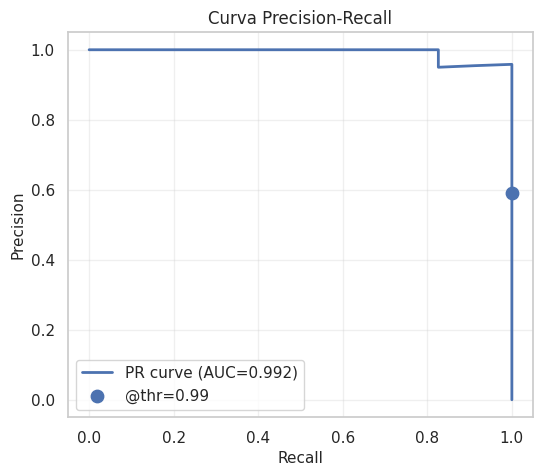

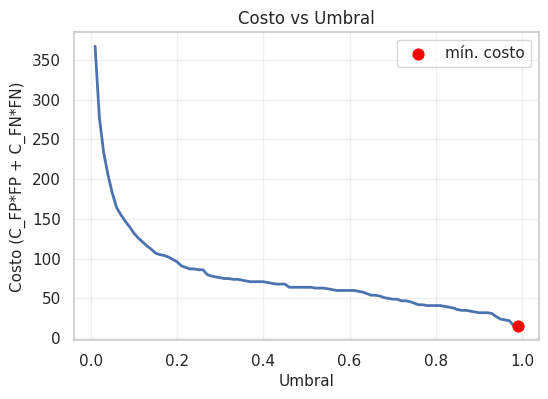

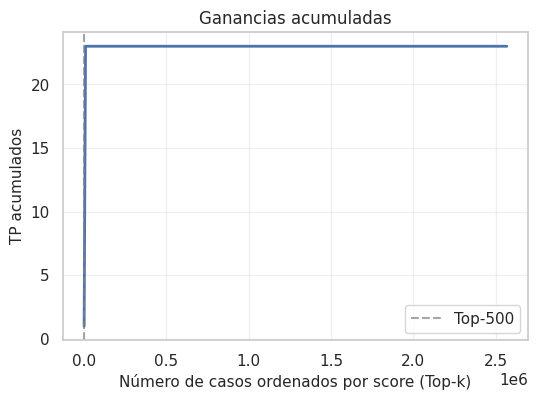

In [ ]:
# ============================================================
# 📊 Sección de Métricas, Umbral y Capacidad Operativa
#    - PR AUC / ROC AUC
#    - Umbral por costo (C_FP, C_FN)
#    - Baseline "amount-only" (sanity check)
#    - Top-N alertas (capacidad operativa)
#    - Gráficos: PR curve, Costo vs Umbral, Ganancias acumuladas
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)

# ---------- Parámetros de negocio / visual ----------
C_FP = 1.0           # costo de un falso positivo
C_FN = 10.0          # costo de un falso negativo
N_ALERTS = 500       # capacidad operativa: cuántas alertas (Top-N) puede revisar el equipo por ciclo
THR_GRID = np.linspace(0.01, 0.99, 99)  # grilla de búsqueda de umbral
MAX_POINTS_PLOT = 300  # para no sobrecargar gráficos con millones de puntos

# ---------- Comprobaciones mínimas ----------
assert 'best_model' in globals(), "Falta 'best_model' en memoria."
assert 'X_test' in globals() and 'y_test' in globals(), "Faltan X_test / y_test."
assert 'df' in globals(), "Falta 'df' (DataFrame base)."

# ---------- Predicciones probabilísticas ----------
y_prob = best_model.predict_proba(X_test)[:, 1]
y_true = y_test.values

# ---------- Métricas globales ----------
pr_auc = average_precision_score(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
print(f"✅ Métricas globales | PR AUC={pr_auc:.4f} | ROC AUC={roc_auc:.4f}")

# ---------- Baseline "amount-only" (sanity check) ----------
if 'amount' in df.columns:
    score_amount = df.loc[X_test.index, 'amount'].fillna(0).values
    pr_amount = average_precision_score(y_true, score_amount)
    roc_amount = roc_auc_score(y_true, score_amount)
    print(f"🔎 Baseline amount-only → PR AUC={pr_amount:.4f} | ROC AUC={roc_amount:.4f}")
else:
    print("ℹ️ 'amount' no está en df; omito baseline amount-only.")

# ---------- Tabla de sensibilidad de umbral por costo ----------
def sweep_thresholds(y_true, y_prob, C_FP=1.0, C_FN=10.0, grid=THR_GRID):
    rows = []
    from sklearn.metrics import confusion_matrix
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = C_FP*fp + C_FN*fn
        precision = tp / (tp + fp) if (tp+fp)>0 else 0.0
        recall    = tp / (tp + fn) if (tp+fn)>0 else 0.0
        rows.append({
            "thr": float(t), "tp": int(tp), "fp": int(fp),
            "fn": int(fn), "tn": int(tn),
            "precision": float(precision), "recall": float(recall),
            "cost": float(cost)
        })
    return pd.DataFrame(rows)

tab = sweep_thresholds(y_true, y_prob, C_FP=C_FP, C_FN=C_FN, grid=THR_GRID)
tab_sorted = tab.sort_values("cost").reset_index(drop=True)
best_row = tab_sorted.iloc[0]
best_thr = best_row['thr']

print("\n🎯 Umbral óptimo por costo:")
display(tab_sorted.head(10))
print(f"→ Umbral seleccionado (mín. costo): {best_thr:.3f} | "
      f"Precision={best_row['precision']:.3f} | Recall={best_row['recall']:.3f} | Costo={best_row['cost']:.1f}")

# ---------- Reporte en umbral óptimo ----------
y_pred = (y_prob >= best_thr).astype(int)
print("\n🔍 Reporte @best_thr")
print(classification_report(y_true, y_pred, digits=4))
print("Matriz de confusión @best_thr")
print(confusion_matrix(y_true, y_pred))

# ---------- Top-N alertas (capacidad operativa) ----------
order = np.argsort(y_prob)[::-1]
N = min(N_ALERTS, len(order))
top_idx = order[:N]
tp_topN = int(y_true[top_idx].sum())
fp_topN = int(N - tp_topN)
prec_topN = tp_topN / N if N > 0 else 0.0
print(f"\n🧮 Top-{N} alertas: TP={tp_topN} | FP={fp_topN} | Precision={prec_topN:.3f}")

# ---------- Gráficos ----------
plt.figure(figsize=(6, 5))
prec, rec, thr = precision_recall_curve(y_true, y_prob)
plt.plot(rec, prec, lw=2, label=f'PR curve (AUC={pr_auc:.3f})')

# Marca el punto más cercano al umbral elegido
if len(thr) > 0:
    idx = np.argmin(np.abs(thr - best_thr))
    plt.scatter(rec[idx], prec[idx], s=80, marker='o', label=f'@thr={best_thr:.2f}', zorder=3)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Costo vs umbral
plt.figure(figsize=(6, 4))
sample_tab = tab
if len(tab) > MAX_POINTS_PLOT:
    # muestreo para no saturar el gráfico
    step = max(1, len(tab)//MAX_POINTS_PLOT)
    sample_tab = tab.iloc[::step].copy()

plt.plot(sample_tab['thr'], sample_tab['cost'], lw=2)
plt.scatter([best_thr], [best_row['cost']], color='red', s=60, zorder=3, label='mín. costo')
plt.xlabel("Umbral")
plt.ylabel("Costo (C_FP*FP + C_FN*FN)")
plt.title("Costo vs Umbral")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Ganancias acumuladas (TP acumulados vs N)
plt.figure(figsize=(6, 4))
sorted_true = y_true[order]
cum_tp = np.cumsum(sorted_true)
if len(cum_tp) > MAX_POINTS_PLOT:
    ks = np.linspace(1, len(cum_tp), num=MAX_POINTS_PLOT, dtype=int)
else:
    ks = np.arange(1, len(cum_tp)+1)
plt.plot(ks, cum_tp[ks-1], lw=2)
plt.axvline(N, color='gray', linestyle='--', alpha=0.7, label=f'Top-{N}')
plt.xlabel("Número de casos ordenados por score (Top-k)")
plt.ylabel("TP acumulados")
plt.title("Ganancias acumuladas")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Politica de Triaje #

In [ ]:
# ============================================================
# 🧪 TRIAGE 3 NIVELES + EXPORTS (ALTO_RIESGO / REVISAR / OK)
# Requisitos en memoria: best_model, X_test, y_test, df
# Artefactos → /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1
# ============================================================
import os, json
import numpy as np
import pandas as pd

# 0) Comprobaciones mínimas y paths
assert 'best_model' in globals(), "Falta best_model en memoria."
assert 'X_test' in globals() and 'y_test' in globals(), "Faltan X_test / y_test."
assert 'df' in globals(), "Falta df (DataFrame base)."

ART_DIR = "/content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1"
os.makedirs(ART_DIR, exist_ok=True)

# 1) Scores de probabilidad
y_true = y_test.values
y_prob = best_model.predict_proba(X_test)[:, 1]

# 2) Umbrales (ajústalos si lo necesitas)
#    Opcional: intenta cargar thresholds previos si existen
thr_cfg_path = os.path.join(ART_DIR, "thr_suggest.json")
if os.path.exists(thr_cfg_path):
    with open(thr_cfg_path, "r") as f:
        cfg_prev = json.load(f)
    THR_HIGH = float(cfg_prev.get("thr_high", 0.995))
    THR_MED  = float(cfg_prev.get("thr_med",  0.985))
else:
    THR_HIGH = 0.995   # muy estricto → pocas alertas, alta precisión
    THR_MED  = 0.985   # revisión manual prioritaria

print(f"Umbrales usados → THR_HIGH={THR_HIGH:.3f} | THR_MED={THR_MED:.3f}")

# 3) Asignación de triage
def assign_triage(p, thr_high=THR_HIGH, thr_med=THR_MED):
    return np.where(p >= thr_high, "ALTO_RIESGO",
           np.where(p >= thr_med,  "REVISAR", "OK"))

triage = assign_triage(y_prob, THR_HIGH, THR_MED)

# 4) Construir tabla de salida con info útil (según columnas disponibles)
meta_cols = [c for c in [
    'transaction_id','client_id','card_id','date','amount',
    'merchant_city','merchant_state','zip','mcc','use_chip'
] if c in df.columns]

out = pd.DataFrame({
    "index": X_test.index,
    "score": y_prob,
    "is_fraud": y_true,
    "triage": triage
}).set_index("index")

# Adjuntar metadatos desde df (mismas filas del holdout)
if meta_cols:
    out = out.join(df.loc[X_test.index, meta_cols], how="left")

# Ordenar por riesgo (score desc)
out = out.sort_values("score", ascending=False)

# 5) Resumen por banda
def band_metrics(df_band):
    tp = int(df_band['is_fraud'].sum())
    n  = len(df_band)
    fp = int(n - tp)
    prec = tp/n if n>0 else 0.0
    return tp, fp, prec, n

summary_rows = []
for band in ["ALTO_RIESGO","REVISAR","OK"]:
    band_df = out[out['triage']==band]
    tp, fp, prec, n = band_metrics(band_df)
    summary_rows.append({
        "triage": band, "casos": n, "TP": tp, "FP": fp,
        "Precision": round(prec, 4)
    })
summary = pd.DataFrame(summary_rows).sort_values("triage")

print("\n📦 Resumen por banda:")
display(summary)

# 6) Guardar artefactos
triage_csv = os.path.join(ART_DIR, "triage_assignments.csv")
summary_csv = os.path.join(ART_DIR, "triage_summary.csv")
with open(os.path.join(ART_DIR, "triage_thresholds.json"), "w") as f:
    json.dump({"thr_high": float(THR_HIGH), "thr_med": float(THR_MED)}, f, indent=2)

out.to_csv(triage_csv, index=True)
summary.to_csv(summary_csv, index=False)

print("\n✅ Artefactos guardados en:")
print(" -", triage_csv)
print(" -", summary_csv)
print(" -", os.path.join(ART_DIR, "triage_thresholds.json"))

# 7) (Opcional) Vista rápida de las primeras alertas a revisar
print("\n🔎 Top 20 casos (por score):")
display(out.head(20)[['score','is_fraud','triage'] + [c for c in meta_cols if c in out.columns]])


Umbrales usados → THR_HIGH=0.995 | THR_MED=0.985

📦 Resumen por banda:


,triage,casos,TP,FP,Precision
0,ALTO_RIESGO,36,23,13,0.6389
2,OK,2567808,0,2567808,0.0000
1,REVISAR,3,0,3,0.0000



✅ Artefactos guardados en:
 - /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1/triage_assignments.csv
 - /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1/triage_summary.csv
 - /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1/triage_thresholds.json

🔎 Top 20 casos (por score):


,score,is_fraud,triage,client_id,card_id,date,amount,merchant_city,merchant_state,zip,mcc,use_chip
index,,,,,,,,,,,,
2888921,1.000000,1,ALTO_RIESGO,1259,5406,2012-04-10 11:05:00,5913.37,Wilton,CT,6897.0,5932,Swipe Transaction
4373878,1.000000,1,ALTO_RIESGO,1487,4946,2013-05-22 17:28:00,5813.78,ONLINE,NaN,NaN,4411,Online Transaction
6388103,1.000000,1,ALTO_RIESGO,1259,5406,2014-11-13 10:27:00,5654.50,Stamford,CT,6907.0,5732,Swipe Transaction
5793720,1.000000,1,ALTO_RIESGO,1259,2006,2014-06-07 11:06:00,4747.97,Wilton,CT,6897.0,5733,Swipe Transaction
7954241,1.000000,1,ALTO_RIESGO,1259,2006,2015-12-30 12:22:00,4645.71,Wilton,CT,6897.0,5932,Chip Transaction
1167704,1.000000,1,ALTO_RIESGO,1983,3399,2010-12-11 04:34:00,4266.21,ONLINE,NaN,NaN,4411,Online Transaction
9450564,1.000000,1,ALTO_RIESGO,1487,4946,2017-01-26 16:34:00,3925.74,Hermitage,PA,16148.0,5732,Chip Transaction
6634893,1.000000,1,ALTO_RIESGO,1487,4946,2015-01-17 16:17:00,3865.86,Hermitage,PA,16148.0,5732,Chip Transaction
331257,1.000000,1,ALTO_RIESGO,1307,111,2010-04-11 03:21:00,3854.44,ONLINE,NaN,NaN,4411,Online Transaction


# MVP escalable y claro para producción! #

Con fraude tan raro y alto volumen, la opción más coherente es decisionar por ranking + capacidad:

Scorear todo con el modelo.

Auto-bloqueo solo para scores muy altos (umbral fijado por precisión mínima, p.ej. ≥80%).

Revisión humana: tomar el Top-N restante ordenado por pérdida esperada (prob * amount) según la capacidad diaria.

El resto aprobado.

In [ ]:
# ============================================================
# 🚀 MVP Decisioning: Umbral por precisión + Top-N por pérdida esperada
# Reqs: best_model, X_test, y_test, df (con 'amount' y metadatos)
# Guarda artefactos en: /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1
# ============================================================
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 1) Parámetros de negocio (ajusta según tu operación)
MIN_PREC_HIGH = 0.80     # precisión mínima para auto-bloqueo
REVIEW_CAPACITY = 200     # casos/día para revisión humana
ART_DIR = "/content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1"
os.makedirs(ART_DIR, exist_ok=True)

assert 'best_model' in globals()
assert 'X_test' in globals() and 'y_test' in globals()
assert 'df' in globals()
assert 'amount' in df.columns, "Se requiere columna 'amount' para pérdida esperada."

# 2) Scores y helper para encontrar umbral por precisión mínima
y_true = y_test.values
y_prob = best_model.predict_proba(X_test)[:, 1]

def threshold_for_min_precision(y_true, y_prob, target_precision=0.8):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)  # prec/rec len=k+1; thr len=k
    # candidatos con precisión >= objetivo
    mask = prec[:-1] >= target_precision
    if not mask.any():
        return None  # no alcanzable
    # elige el de mayor recall entre los que cumplen precisión
    idxs = np.where(mask)[0]
    best_idx = idxs[np.argmax(rec[:-1][mask])]
    return float(thr[best_idx])

THR_HIGH = threshold_for_min_precision(y_true, y_prob, MIN_PREC_HIGH)
if THR_HIGH is None:
    # Fallback: toma un umbral alto fijo si no se alcanza esa precisión (caso extremo)
    THR_HIGH = float(np.quantile(y_prob, 0.999))  # top 0.1% como bloqueo
    print(f"⚠️ No se alcanzó precisión {MIN_PREC_HIGH:.0%}. Uso fallback THR_HIGH={THR_HIGH:.3f}")
else:
    print(f"🎯 THR_HIGH elegido por precisión mínima {MIN_PREC_HIGH:.0%}: {THR_HIGH:.3f}")

# 3) Asignación de triage
high_mask = y_prob >= THR_HIGH
low_mask  = ~high_mask

# Pérdida esperada para priorizar revisión (solo en los no bloqueados)
amount_test = df.loc[X_test.index, 'amount'].fillna(0).values
expected_loss = y_prob * amount_test

order_low_by_loss = np.argsort(expected_loss[low_mask])[::-1]
review_take = min(REVIEW_CAPACITY, order_low_by_loss.shape[0])

triage = np.full_like(y_prob, fill_value='OK', dtype=object)
triage[high_mask] = 'ALTO_RIESGO'
if review_take > 0:
    # indices en el vector completo
    low_indices = np.where(low_mask)[0]
    review_indices = low_indices[order_low_by_loss[:review_take]]
    triage[review_indices] = 'REVISAR'

# 4) Construir salida y métricas por banda
meta_cols = [c for c in ['transaction_id','client_id','card_id','date',
                         'amount','merchant_city','merchant_state','zip','mcc','use_chip']
             if c in df.columns]
out = pd.DataFrame({
    "index": X_test.index,
    "score": y_prob,
    "is_fraud": y_true,
    "expected_loss": expected_loss,
    "triage": triage
}).set_index("index").sort_values("score", ascending=False)

if meta_cols:
    out = out.join(df.loc[X_test.index, meta_cols], how="left")

def band_summary(df_band):
    n = len(df_band)
    tp = int(df_band['is_fraud'].sum())
    fp = n - tp
    prec = tp/n if n>0 else 0.0
    return n, tp, fp, prec

sum_rows=[]
for band in ["ALTO_RIESGO","REVISAR","OK"]:
    band_df = out[out['triage']==band]
    n, tp, fp, prec = band_summary(band_df)
    sum_rows.append({"triage": band, "casos": n, "TP": tp, "FP": fp, "Precision": round(prec,4)})
summary = pd.DataFrame(sum_rows).sort_values("triage")

print("\n📦 Resumen por banda (MVP):")
display(summary)

# Reporte en la banda ALTO_RIESGO (referencia)
y_pred_high = (y_prob >= THR_HIGH).astype(int)
print("\n🔍 Reporte solo @ALTO_RIESGO (umbral alto)")
print(classification_report(y_true, y_pred_high, digits=4))
print("Matriz de confusión @ALTO_RIESGO")
print(confusion_matrix(y_true, y_pred_high))

# 5) Exportar artefactos para la app/BI
out_path = os.path.join(ART_DIR, "triage_mvp_assignments.csv")
sum_path = os.path.join(ART_DIR, "triage_mvp_summary.csv")
cfg_path = os.path.join(ART_DIR, "triage_mvp_thresholds.json")

out.to_csv(out_path)
summary.to_csv(sum_path, index=False)
with open(cfg_path, "w") as f:
    json.dump({
        "thr_high": THR_HIGH,
        "min_precision_high": MIN_PREC_HIGH,
        "review_capacity": int(REVIEW_CAPACITY),
        "policy": "auto-block by min precision; review Top-N by expected_loss; rest OK"
    }, f, indent=2)

print("\n✅ Exportado:")
print(" -", out_path)
print(" -", sum_path)
print(" -", cfg_path)

# 6) Vistazo a las primeras alertas
print("\n🔎 Top 20 por score:")
display(out.head(20)[['score','expected_loss','is_fraud','triage'] + [c for c in meta_cols if c in out.columns]])


🎯 THR_HIGH elegido por precisión mínima 80%: 0.999

📦 Resumen por banda (MVP):


,triage,casos,TP,FP,Precision
0,ALTO_RIESGO,28,23,5,0.8214
2,OK,2567619,0,2567619,0.0000
1,REVISAR,200,0,200,0.0000



🔍 Reporte solo @ALTO_RIESGO (umbral alto)
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   2567824
           1     0.8214    1.0000    0.9020        23

    accuracy                         1.0000   2567847
   macro avg     0.9107    1.0000    0.9510   2567847
weighted avg     1.0000    1.0000    1.0000   2567847

Matriz de confusión @ALTO_RIESGO
[[2567819       5]
 [      0      23]]

✅ Exportado:
 - /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1/triage_mvp_assignments.csv
 - /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1/triage_mvp_summary.csv
 - /content/drive/MyDrive/Proyecto_Fraude/artifacts_noleak_v1/triage_mvp_thresholds.json

🔎 Top 20 por score:


,score,expected_loss,is_fraud,triage,client_id,card_id,date,amount,merchant_city,merchant_state,zip,mcc,use_chip
index,,,,,,,,,,,,,
2888921,1.000000,5913.370000,1,ALTO_RIESGO,1259,5406,2012-04-10 11:05:00,5913.37,Wilton,CT,6897.0,5932,Swipe Transaction
4373878,1.000000,5813.780000,1,ALTO_RIESGO,1487,4946,2013-05-22 17:28:00,5813.78,ONLINE,NaN,NaN,4411,Online Transaction
6388103,1.000000,5654.500000,1,ALTO_RIESGO,1259,5406,2014-11-13 10:27:00,5654.50,Stamford,CT,6907.0,5732,Swipe Transaction
5793720,1.000000,4747.970000,1,ALTO_RIESGO,1259,2006,2014-06-07 11:06:00,4747.97,Wilton,CT,6897.0,5733,Swipe Transaction
7954241,1.000000,4645.710000,1,ALTO_RIESGO,1259,2006,2015-12-30 12:22:00,4645.71,Wilton,CT,6897.0,5932,Chip Transaction
1167704,1.000000,4266.209998,1,ALTO_RIESGO,1983,3399,2010-12-11 04:34:00,4266.21,ONLINE,NaN,NaN,4411,Online Transaction
9450564,1.000000,3925.739926,1,ALTO_RIESGO,1487,4946,2017-01-26 16:34:00,3925.74,Hermitage,PA,16148.0,5732,Chip Transaction
6634893,1.000000,3865.859900,1,ALTO_RIESGO,1487,4946,2015-01-17 16:17:00,3865.86,Hermitage,PA,16148.0,5732,Chip Transaction
331257,1.000000,3854.439840,1,ALTO_RIESGO,1307,111,2010-04-11 03:21:00,3854.44,ONLINE,NaN,NaN,4411,Online Transaction


In [ ]:
!pip freeze | grep -E 'scikit-learn|numpy|pandas|joblib|lightgbm'

joblib==1.5.2
numpy==2.0.2
pandas==2.2.2
pandas-stubs==2.2.2.240909
scikit-learn==1.6.1
sklearn-pandas==2.2.0
